# Master Thesis - Data Handling

### Kristoffer Stjern & Daniel W. Kabré

# -----------------------------------------------------------------------------------------

# Chapter 0) Settings

## 0.1) Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime as dt
import statsmodels.api as sm
import warnings
from statsmodels.tsa.stattools import adfuller
warnings.simplefilter("ignore")

## 0.2) Parameters

In [2]:
start_date = dt.datetime.strptime("31/12/1998", "%d/%m/%Y")
start_date_2 = dt.datetime.strptime("01/01/1998", "%d/%m/%Y")
end_date = dt.datetime.strptime("01/01/2025", "%d/%m/%Y")

# Chapter 1) Importing Data

In [3]:
cwd = os.getcwd()

## 1.1) Monetary Decision Dates

### 1.1.1) Exact Dates and Time

In [4]:
monetary_dates = pd.read_excel("Data/Dates & Times.xlsx",sheet_name="Monetary decisions").iloc[::-1]
monetary_dates.index = pd.to_datetime(monetary_dates["Monetary Decisions (t=0)"])
monetary_dates.drop("Monetary Decisions (t=0)",axis=1,inplace=True)

### 1.1.2) Monthly Series

In [5]:
monthly_dates = pd.read_excel("Data/Dates & Times.xlsx",sheet_name="Monthly").iloc[::-1]
monthly_dates.index = pd.to_datetime(monthly_dates["Monetary Decisions (t=0)"])
monthly_dates.drop("Monetary Decisions (t=0)",axis=1,inplace=True)
monthly_dates = monthly_dates.index.to_period("M")

### 1.1.3) Daily Series

In [6]:
daily_dates = pd.read_excel("Data/Dates & Times.xlsx",sheet_name="Daily").iloc[::-1]
daily_dates_t = pd.to_datetime(daily_dates["Monetary Decisions (t=0)"]).dt.to_period("D")
daily_dates.index = pd.to_datetime(daily_dates["Monetary Decisions (t=0)"])
daily_dates.drop("Monetary Decisions (t=0)",axis=1,inplace=True)

In [7]:
daily_dates_t

206    1999-01-17
205    1999-03-03
204    1999-04-23
203    1999-06-16
202    1999-08-25
          ...    
4      2024-06-20
3      2024-08-15
2      2024-09-19
1      2024-11-07
0      2024-12-19
Name: Monetary Decisions (t=0), Length: 207, dtype: period[D]

In [8]:
daily_dates["(t+1)"] = pd.to_datetime(daily_dates["(t+1)"])
t_pluss_1 = pd.DataFrame(index=daily_dates["(t+1)"].dt.to_period("D"))

daily_dates["(t-1)"] = pd.to_datetime(daily_dates["(t-1)"])
t_min_1 = pd.DataFrame(index=daily_dates["(t-1)"].dt.to_period("D"))

### 1.1.4) Intraday Series (30 min difference)

In [9]:
intra_day_dates = pd.read_excel("Data/Dates & Times.xlsx",sheet_name="Intra day").iloc[::-1]
intra_day_dates.index = pd.to_datetime(intra_day_dates["Monetary Decisions (t=0)"])
intra_day_dates.drop("Monetary Decisions (t=0)",axis=1,inplace=True)

## 1.2) Index Returns (OSEAX)

In [10]:
OSEAX = pd.read_excel("Data/Stock/Index/OSEAX.xlsx",header=0,skiprows=6)
OSEAX.index = pd.to_datetime(OSEAX["Date"])
OSEAX.drop(["Date","OSEAX"],axis=1,inplace=True)
OSEAX_monthly = OSEAX.resample("M").last()
OSEAX_monthly.columns = ["OSEAX"]

In [11]:
OSEAX_returns = OSEAX_monthly.pct_change().loc[start_date:end_date]

## 1.3) Firm Level Data

### 1.3.0) Identifying Unrelevant Series

In [12]:
bad_names = ["#ERROR","DNB NOR OBX"]

### 1.3.1) Firm Excess Returns

In [13]:
Stock_prices = pd.read_excel("Data/Stock/Firm/Firm_level_data.xlsx",sheet_name ="Price", header=0,skiprows=3).iloc[:,2:]
Stock_prices.index = pd.to_datetime(Stock_prices["Date"])
Stock_prices.drop(["Date"],axis=1,inplace=True)
Stock_prices = Stock_prices.resample("M").last()
Stock_prices.drop(bad_names ,axis=1,inplace=True)
firm_returns = Stock_prices.pct_change().loc[start_date:end_date]

In [14]:
firm_excess_returns = firm_returns.sub(OSEAX_returns["OSEAX"], axis=0)
firm_excess_returns.index = firm_excess_returns.index.to_period("d")
x = (firm_returns== 0).mean().sort_values(ascending=False).head(30).index
firm_excess_returns.drop(x,axis=1,inplace=True)

In [15]:
firm_excess_returns

,AWILCO DRILLING,PANORO ENERGY,SAGA PURE,WALLENIUS WILHELMSEN,KMC PROPERTIES,ARCHER,GJENSIDIGE FORSIKRING,S D STANDARD ETC,AWILCO LNG,HOFSETH BIOCARE,...,FLEKKEFJORD SPAREB,VENTURA OFFSHORE HOLDING,CAVENDISH HYDROGEN,HERMANA HOLDING,PARATUS ENERGY SER,HAUGESUND SPAREBANK,BRUTON,ONCOINVENT,TRONDELAG SPAREBANK,MORELD
Date,,,,,,,,,,,,,,,,,,,,,
1998-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.210494,-0.098349,0.013603,0.095457,0.196529,-0.101839,0.031479,0.116633,-0.024249,0.013603,...,-0.004255,-0.115173,-0.395000,-0.135252,-0.062155,0.043014,NaN,NaN,NaN,NaN
2024-09-30,-0.044530,-0.074214,0.055758,0.148254,0.115732,-0.039618,0.066635,0.016076,-0.035955,-0.127489,...,0.020621,0.056222,0.078803,0.034013,0.007879,0.084219,NaN,NaN,NaN,NaN
2024-10-31,0.003156,-0.006923,-0.033569,-0.139493,-0.120044,0.030705,-0.005096,0.027793,-0.188714,-0.201420,...,-0.006144,-0.028213,-0.051729,-0.094369,-0.118841,-0.034341,NaN,NaN,NaN,NaN


### 1.3.2) Firm Industry Classifications

In [16]:
Stock_info = pd.read_excel("Data/Stock/Firm/Firm_level_data.xlsx",header=0)

### 1.3.3) Firm P/B

In [17]:
Stock_PB = pd.read_excel("Data/Stock/Firm/Firm_level_data.xlsx",sheet_name ="Price to Book", header=0,skiprows=2).iloc[:,2:]
Stock_PB.index = pd.to_datetime(Stock_PB["Date"])
Stock_PB.drop(["Date"],axis=1,inplace=True)
Stock_PB.drop(bad_names ,axis=1,inplace=True)
filtered_PB = Stock_PB.loc[start_date:end_date]
filtered_PB.index = filtered_PB.index.to_period("M")
filtered_PB.drop(x,axis=1,inplace=True)

### 1.3.4) Firm Debt To Assets

In [18]:
Stock_Debt = pd.read_excel("Data/Stock/Firm/Firm_level_data.xlsx",sheet_name ="Debt to Assets", header=0,skiprows=5).iloc[:,3:]
Stock_Debt.index = pd.to_datetime(Stock_Debt["Date"])
Stock_Debt.drop(["Date"],axis=1,inplace=True)
Stock_Debt.drop(bad_names ,axis=1,inplace=True)
filtered_Debt = Stock_Debt.loc[start_date:end_date]
filtered_Debt.index = filtered_Debt.index.to_period("M")
filtered_Debt.drop(x,axis=1,inplace=True)

### 1.3.5) Firm Dividend Yield

In [19]:
Stock_Dividend = pd.read_excel("Data/Stock/Firm/Firm_level_data.xlsx",sheet_name ="Dividend payout", header=0,skiprows=3).iloc[:,3:]
Stock_Dividend.index = pd.to_datetime(Stock_Dividend["Date"])
Stock_Dividend.drop(["Date"],axis=1,inplace=True)
Stock_Dividend.drop(bad_names ,axis=1,inplace=True)
filtered_Dividend = Stock_Dividend.loc[start_date_2:end_date].resample("Y").last()
filtered_Dividend.index = filtered_Dividend.index.to_period("M")
filtered_Dividend.drop(x,axis=1,inplace=True)

### 1.3.6) Firm Market Cap

In [20]:
Stock_MC = pd.read_excel("Data/Stock/Firm/Firm_level_data.xlsx",sheet_name ="Market cap", header=0,skiprows=3).iloc[:,2:]
Stock_MC.index = pd.to_datetime(Stock_MC["Date"])
Stock_MC.drop(["Date"],axis=1,inplace=True)
Stock_MC.drop(bad_names ,axis=1,inplace=True)
filtered_MC = Stock_MC.loc[start_date:end_date]
filtered_MC.index = filtered_MC.index.to_period("M")
filtered_MC.drop(x,axis=1,inplace=True)

### 1.3.8) Firm Profit Margin

In [21]:
Stock_Margin = pd.read_excel("Data/Stock/Firm/Firm_level_data.xlsx",sheet_name ="Profit Margin", header=0,skiprows=5).iloc[:,3:]
Stock_Margin.index = pd.to_datetime(Stock_Margin["Date"])
Stock_Margin.drop(["Date"],axis=1,inplace=True)
Stock_Margin.drop(bad_names ,axis=1,inplace=True)
filtered_Margin = Stock_Margin.loc[start_date_2:end_date]
filtered_Margin.index = filtered_Margin.index.to_period("M")
filtered_Margin = filtered_Margin.shift(1)
filtered_Margin.drop(x,axis=1,inplace=True)

### 1.3.9) Interest rate coverage

In [22]:
IRC = pd.read_excel("Data/Stock/Firm/Firm_level_data.xlsx",sheet_name ="Interest rate coverage", header=0,skiprows=5).iloc[:,3:]
IRC.index = pd.to_datetime(IRC["Date"])
IRC.drop("Date",axis=1,inplace=True)
IRC.drop(bad_names ,axis=1,inplace=True)
filtered_IRC = IRC.loc[start_date_2:end_date]
filtered_IRC.index = filtered_IRC.index.to_period("M")
filtered_IRC = filtered_IRC.shift(1)
filtered_IRC.drop(x,axis=1,inplace=True)

### 1.3.10) Short Term Debt percentage

In [23]:
Short_debt = pd.read_excel("Data/Stock/Firm/Firm_level_data.xlsx",sheet_name ="Short term debt percentage", header=0,skiprows=5).iloc[:,3:]
Short_debt.index = pd.to_datetime(Short_debt["Date"])
Short_debt.drop("Date",axis=1,inplace=True)
Short_debt.drop(bad_names ,axis=1,inplace=True)
filtered_Short_debt = Short_debt.loc[start_date_2:end_date]
filtered_Short_debt.index = filtered_Short_debt.index.to_period("M")
filtered_Short_debt = filtered_Short_debt.shift(1)
filtered_Short_debt.drop(x,axis=1,inplace=True)

In [24]:
filtered_Short_debt

,AWILCO DRILLING,PANORO ENERGY,SAGA PURE,WALLENIUS WILHELMSEN,KMC PROPERTIES,ARCHER,GJENSIDIGE FORSIKRING,S D STANDARD ETC,AWILCO LNG,HOFSETH BIOCARE,...,FLEKKEFJORD SPAREB,VENTURA OFFSHORE HOLDING,CAVENDISH HYDROGEN,HERMANA HOLDING,PARATUS ENERGY SER,HAUGESUND SPAREBANK,BRUTON,ONCOINVENT,TRONDELAG SPAREBANK,MORELD
Date,,,,,,,,,,,,,,,,,,,,,
1998-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.4) Control Variables

### 1.4.1) CPI

In [25]:
CPI = pd.read_excel("Data/Controll Variables/CPI.xlsx",skiprows=5,header=0).iloc[::-1]
CPI.index = pd.to_datetime(CPI["Date"])
CPI.drop(["Date","PX_MID"],axis=1,inplace=True)
CPI.columns = ["CPI"]
CPI.index = CPI.index.to_period("M")

### 1.4.2) EPU

In [26]:
EPU = pd.read_excel("Data/Controll Variables/Global EPU.xlsx")
EPU["Day"] = 1

EPU.index = pd.to_datetime(EPU[['Year','Month',"Day"]],format="%Y%m%d")
EPU.drop(["Year","Month","Day"],axis=1,inplace=True)
EPU.index = EPU.index.to_period("M")

### 1.4.3) Brent Oil

In [27]:
Brent_price = pd.read_excel("Data/Controll Variables/Oil price.xlsx",header=0,skiprows=4).iloc[:,3:]
Brent_price.index = pd.to_datetime(Brent_price["Date"])
Brent_price.drop(["Date"],axis=1,inplace=True)
Brent_price.columns = ["Brent"]
Brent_price.index = Brent_price.index.to_period("M")

### 1.4.4) Unemployment 

In [28]:
Unemployment = pd.read_excel("Data/Controll Variables/Unemployment.xlsx",header=0,skiprows=2).iloc[:,1:]

In [29]:
Q_dates = ["/03/31","/06/30","/09/30","/12/31"]


for i in range(len(Unemployment)):
    date = Unemployment["Unnamed: 1"][i]
    year, Q = date.split("K")
    
    
    if Q == "1":
        new_date = f'{year}'+Q_dates[0]
        
        Unemployment.iloc[i,0] = new_date
        
    elif Q == "2":
        new_date = f'{year}'+Q_dates[1]
        
        Unemployment.iloc[i,0] = new_date
        
    elif Q == "3":
        new_date = f'{year}'+Q_dates[2]
        
        Unemployment.iloc[i,0] = new_date
        
    else:
        new_date = f'{year}'+Q_dates[3]
        
        Unemployment.iloc[i,0] = new_date
    
    
        
    

In [30]:
Unemployment.index = pd.to_datetime(Unemployment["Unnamed: 1"])
Unemployment.drop(["Unnamed: 1","Arbeidsledige (1 000 personer)"],axis=1,inplace=True)
Unemployment.index = Unemployment.index.to_period("M")

### 1.4.5) PPI

In [31]:
PPI = pd.read_excel("Data/Controll Variables/PPI.xlsx",header=0,skiprows=2).iloc[:,:3]

In [32]:
for i in range(len(PPI)):
    date = PPI["Unnamed: 0"][i]
    year, Q = date.split("M")
    
    

    new_date = f'{year}'+f'/{Q}'
        
    PPI.iloc[i,0] = new_date
        

PPI.index = pd.to_datetime(PPI["Unnamed: 0"], format="%Y/%m")
PPI.drop(["Unnamed: 0"],axis=1,inplace=True)
PPI.index = PPI.index.to_period("M")

### 1.4.6) USD/NOK Exchange Rate

In [33]:
USD_NOK = pd.read_excel("Data/Controll Variables/USDNOK_Valutakurs.xlsx",header=0,skiprows=1)
USD_NOK.index = pd.to_datetime(USD_NOK["Date"])
USD_NOK.drop(["Date"],axis=1,inplace=True)
USD_NOK.index = USD_NOK.index.to_period("M")

### 1.4.7) EU Volatility

In [34]:
EU_vol = pd.read_excel("Data/Controll Variables/VSTOXX.xlsx",header=0,skiprows=6)
EU_vol.index = pd.to_datetime(EU_vol["Date"])
EU_vol.drop(["Date"],axis=1,inplace=True)
EU_vol.columns = ["EU Volatility"]
EU_vol.index = EU_vol.index.to_period("M")

## 1.5) Monetary Policy Shocks

To calculate the BRW variable, we need the 1-day difference in government yields around the Monetary Policy Decision dates.

### 1.5.1) BRW

#### Processing Government Yields

In [35]:
Gov_yields = pd.read_excel("Data/Yields/Government bonds/GOV_Yields.xlsx").iloc[:,3:]
Gov_yields.index = pd.to_datetime(Gov_yields["Date"])
Gov_yields.drop(["Date"],axis=1,inplace=True)

filtered_gov_yields = Gov_yields[["NORWAY GVT BMK BID YLD 6M - RED. YIELD","NORWAY GVT BMK BID YLD 9M - RED. YIELD",
                                  "NORWAY GVT BMK BID YLD 1Y - RED. YIELD","NORWAY GVT BMK BID YLD 3Y - RED. YIELD",
                                  "NORWAY GVT BMK BID YLD 5Y - RED. YIELD","NORWAY GVT BMK BID YLD 10Y - RED. YIELD"]].loc[start_date:end_date]

filtered_gov_yields.index = filtered_gov_yields.index.to_period("d")

In [36]:
Gov_yields

,NORWAY GVT BMK BID YLD 6M - RED. YIELD,#ERROR,#ERROR.1,NORWAY GVT BMK BID YLD 9M - RED. YIELD,#ERROR.2,#ERROR.3,NORWAY GVT BMK BID YLD 1Y - RED. YIELD,#ERROR.4,#ERROR.5,NORWAY GVT BMK BID YLD 3Y - RED. YIELD,#ERROR.6,#ERROR.7,NORWAY GVT BMK BID YLD 5Y - RED. YIELD,#ERROR.8,#ERROR.9,NORWAY GVT BMK BID YLD 10Y - RED. YIELD,#ERROR.10,#ERROR.11
Date,,,,,,,,,,,,,,,,,,
1990-01-01,NaN,"$$ER: E100,INVALID CODE OR EXPRESSION ENTERED","$$ER: E100,INVALID CODE OR EXPRESSION ENTERED",NaN,"$$ER: E100,INVALID CODE OR EXPRESSION ENTERED","$$ER: E100,INVALID CODE OR EXPRESSION ENTERED",NaN,"$$ER: E100,INVALID CODE OR EXPRESSION ENTERED","$$ER: E100,INVALID CODE OR EXPRESSION ENTERED",NaN,"$$ER: E100,INVALID CODE OR EXPRESSION ENTERED","$$ER: E100,INVALID CODE OR EXPRESSION ENTERED",NaN,"$$ER: E100,INVALID CODE OR EXPRESSION ENTERED","$$ER: E100,INVALID CODE OR EXPRESSION ENTERED",11.030,"$$ER: E100,INVALID CODE OR EXPRESSION ENTERED","$$ER: E100,INVALID CODE OR EXPRESSION ENTERED"
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.020,NaN,NaN
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.020,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.020,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.020,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,4.472,NaN,NaN,4.384,NaN,NaN,4.308,NaN,NaN,3.863,NaN,NaN,3.773,NaN,NaN,3.793,NaN,NaN
2024-12-26,4.472,NaN,NaN,4.384,NaN,NaN,4.308,NaN,NaN,3.863,NaN,NaN,3.773,NaN,NaN,3.793,NaN,NaN
2024-12-27,4.582,NaN,NaN,4.434,NaN,NaN,4.347,NaN,NaN,3.876,NaN,NaN,3.826,NaN,NaN,3.853,NaN,NaN


#### Yields in (T-1) from decision

In [37]:
yields_minus_1 = pd.DataFrame( index = daily_dates.index.to_period("d"),columns =filtered_gov_yields.columns )

In [38]:
for i in range(len(t_min_1)):
    date = t_min_1.index[i]
    if date in filtered_gov_yields.index:
        result = filtered_gov_yields.loc[date]
    else:
        result = None

    if result is None:
        date = date -1
        if date in filtered_gov_yields.index:
            result = filtered_gov_yields.loc[date]
        else:
            result = None
            date = date -1
            result = filtered_gov_yields.loc[date]

  
    
    yields_minus_1.iloc[i,:] = result
    


    

#### Yields in (T+1) from decision

In [39]:
yields_pluss_1 = pd.DataFrame( index = daily_dates.index.to_period("d"),columns =filtered_gov_yields.columns )

In [40]:
for i in range(len(t_pluss_1)):
    date = t_pluss_1.index[i]
    if date in filtered_gov_yields.index:
        result = filtered_gov_yields.loc[date]
    else:
        result = None

    if result is None:
        date = date + 1
        if date in filtered_gov_yields.index:
            result = filtered_gov_yields.loc[date]
        else:
            result = None
            date = date + 1
            result = filtered_gov_yields.loc[date]

  
    
    yields_pluss_1.iloc[i,:] = result

#### Finding the yield difference between (t+1) and (t-1)

In [41]:
change_yields  = (yields_pluss_1 - yields_minus_1)

In [42]:
change_yields = change_yields.fillna(0)
change_yields.columns = ["6M","9M","1Y","3Y","5Y","10Y"]

### 1.5.2) FF4

In [43]:
swr1 = pd.read_excel("Data/Yields/Swaps/Swap rates.xlsx",sheet_name="1Y",skiprows = 9).iloc[:,2:]
swr1.index = pd.to_datetime(swr1["Date"])
swr1.drop("Date",axis = 1,inplace=True)


swr3 = pd.read_excel("Data/Yields/Swaps/Swap rates.xlsx",sheet_name="3Y",skiprows = 7).iloc[:,2:]
swr3.index = pd.to_datetime(swr3["Date"])
swr3.drop("Date",axis = 1,inplace=True)

swr5 = pd.read_excel("Data/Yields/Swaps/Swap rates.xlsx",sheet_name="5Y",skiprows = 8).iloc[:,2:]
swr5.index = pd.to_datetime(swr5["Date"])
swr5.drop("Date",axis = 1,inplace=True)

swr10 = pd.read_excel("Data/Yields/Swaps/Swap rates.xlsx",sheet_name="10Y",skiprows = 9).iloc[:,2:]
swr10.index = pd.to_datetime(swr10["Date"])
swr10.drop("Date",axis = 1,inplace=True)

swr =  swr1[::-1]
swr.index = swr.index.to_period("D")

In [44]:

swr_tmin1 = pd.DataFrame(columns = ["1Y"],index = daily_dates_t)

for i in range(3,len(t_min_1)):
    
    date = t_min_1.index[i]

    if date in swr.index:
        result = swr.loc[date]
    else:
        
        result = swr[swr.index < date]
        
 

  


  
    
    swr_tmin1.iloc[i,:] = result.iloc[-1]


In [45]:
swr_tpluss1 = pd.DataFrame(columns = ["1Y"],index = daily_dates_t )

for i in range(3,len(t_pluss_1)):
    
    date = t_pluss_1.index[i]
    if date in swr.index:
        result = swr.loc[date]
    else:
        result = result = swr[swr.index > date]
  
    
    swr_tpluss1.iloc[i,:] = result.iloc[0]

# Chapter 2) Creating Variables

## 2.1) Excess Returns (T + K)

In [46]:
excess_lagged_1 = firm_excess_returns.shift(-1)

excess_lagged_2 = firm_excess_returns.shift(-2)


excess_lagged_3 = firm_excess_returns.shift(-3)


excess_lagged_4 = firm_excess_returns.shift(-4)


excess_lagged_5 = firm_excess_returns.shift(-5)


excess_lagged_6 = firm_excess_returns.shift(-6)


excess_lagged_7 = firm_excess_returns.shift(-7)



## 2.2) Firm Characteristics

To properly utilize the firm-level characteristics, we need to isolate the relevant dates from their respective time series that align with the monetary policy decision dates. Additionally, we must lag the characteristics to eliminate the risk of forward-looking bias.

### 2.2.1) Firm Margin

In [47]:
filtered_alligned_margin = pd.DataFrame(columns =filtered_Margin.columns ,index = monthly_dates)

for i in range(len(filtered_alligned_margin)):
    date = filtered_alligned_margin.index[i]
    
    num =  filtered_Margin.loc[ filtered_Margin.index <date].iloc[-1,:]
  

    filtered_alligned_margin.iloc[i,:] = num

filtered_alligned_margin.index = daily_dates_t

### 2.2.2) Firm Market Cap

In [48]:
lagged_MC = filtered_MC.shift(1)
lagged_filtered_MC = lagged_MC.loc[monthly_dates] 
lagged_filtered_MC.index = daily_dates_t

### 2.2.3) Firm P/B

In [49]:
lagged_PB = filtered_PB.shift(1)
lagged_filtered_PB = lagged_PB.loc[monthly_dates] 
lagged_filtered_PB.index = daily_dates_t

### 2.2.4) Firm Dividend Yield

In [50]:
filtered_alligned_dividend = pd.DataFrame(columns =filtered_Dividend.columns ,index = monthly_dates)

for i in range(len(filtered_alligned_dividend)):
    date = filtered_alligned_dividend.index[i]
    
    num =  filtered_Dividend.loc[ filtered_Dividend.index <date].iloc[-1,:]
  

    filtered_alligned_dividend.iloc[i,:] = num

filtered_alligned_dividend.index = daily_dates_t

### 2.2.5) Firm Debt to Assets

In [51]:
dropped_filtered_debt = filtered_Debt.shift(1)
filtered_alligned_debt = pd.DataFrame(columns =dropped_filtered_debt.columns ,index = monthly_dates)

for i in range(len(filtered_alligned_debt)):
    date = filtered_alligned_debt.index[i]
    
    num =  dropped_filtered_debt.loc[ dropped_filtered_debt.index <=date].iloc[-1,:]
  

    filtered_alligned_debt.iloc[i,:] = num
filtered_alligned_debt.index = daily_dates_t

### 2.2.6) Interest coverage ratio

In [52]:
dropped_filtered_IRC = filtered_IRC.shift(1)
filtered_alligned_IRC = pd.DataFrame(columns =dropped_filtered_IRC.columns ,index = monthly_dates)

for i in range(len(filtered_alligned_IRC)):
    date = filtered_alligned_IRC.index[i]
    
    num =  dropped_filtered_IRC.loc[ dropped_filtered_IRC.index <=date].iloc[-1,:]
  

    filtered_alligned_IRC.iloc[i,:] = num
filtered_alligned_IRC.index = daily_dates_t

### 2.2.7) Short-term debt ratio

In [53]:
dropped_filtered_Short_debt = filtered_Short_debt.shift(1)
filtered_alligned_Short_debt = pd.DataFrame(columns =dropped_filtered_Short_debt.columns ,index = monthly_dates)

for i in range(len(filtered_alligned_Short_debt)):
    date = filtered_alligned_Short_debt.index[i]
    
    num =  dropped_filtered_Short_debt.loc[ dropped_filtered_Short_debt.index <=date].iloc[-1,:]
  

    filtered_alligned_Short_debt.iloc[i,:] = num
filtered_alligned_Short_debt.index = daily_dates_t

## 2.3) Control Variables

### 2.3.1) CPI

In [54]:
lagged_CPI = CPI.shift(1)
filtered_lagged_CPI = lagged_CPI.loc[monthly_dates] 
filtered_lagged_CPI.index = daily_dates_t

### 2.3.2) Employment

In [55]:
lagged_Unemployment = Unemployment.shift(1)
filtered_lagged_Unemployment = pd.DataFrame(columns = ["Unemployment"],index = monthly_dates)

for i in range(len(filtered_lagged_Unemployment)):
    date = filtered_lagged_Unemployment.index[i]
    num = lagged_Unemployment.iloc[lagged_Unemployment.index < date].iloc[-1,0]
    filtered_lagged_Unemployment.iloc[i,0] = num
filtered_lagged_Unemployment.index = daily_dates_t

### 2.3.3) EPU

In [56]:
lagged_EPU = EPU.shift(1)
filtered_lagged_EPU = lagged_EPU.loc[monthly_dates] 
filtered_lagged_EPU.index = daily_dates_t

### 2.3.4) PMI

In [57]:
PPI

,Producer price index (2021=100),Montly change (per cent)
Unnamed: 0,,
2000-01,29.9,0.3
2000-02,31.0,3.7
2000-03,31.3,1.0
2000-04,29.7,-5.1
2000-05,32.1,8.1
...,...,...
2024-08,117.8,1.9
2024-09,115.6,-1.9
2024-10,120.9,4.6


In [58]:
# Create an empty DataFrame with the desired index
filtered_lagged_PPI = pd.DataFrame(None, index=monthly_dates)

# Assign a column "PMI" with None (or NaN) values
filtered_lagged_PPI["PMI"] = None

# Shift the `PPI` series by 1
lagged_PPI = PPI.shift(1)

# Iterate through each date in `monthly_dates` (to preserve duplicates)
for i in range(len(monthly_dates)):
    date = monthly_dates[i].to_timestamp()
    non_form_date = monthly_dates[i]
    
    # For each date, get the corresponding values from `lagged_PPI`
    if date in lagged_PPI.index:
        filtered_lagged_PPI.loc[filtered_lagged_PPI.index == non_form_date, "PMI"] = lagged_PPI.loc[date, "Producer price index (2021=100)"]
filtered_lagged_PPI.index= daily_dates_t

### 2.3.5) EU VOL

In [59]:
lagged_EU_vol = EU_vol.shift(1)
filtered_lagged_EU_vol = lagged_EU_vol.loc[monthly_dates] 
filtered_lagged_EU_vol.index = daily_dates_t

### 2.3.6) USD/NOK

In [60]:
lagged_USD_NOK = USD_NOK.shift(1)
filtered_lagged_USD_NOK = lagged_USD_NOK.loc[monthly_dates] 
filtered_lagged_USD_NOK.index = daily_dates_t

### 2.3.7) Brent Price

In [61]:
lagged_Brent_price = Brent_price.shift(1)
filtered_lagged_Brent_price = lagged_Brent_price.loc[monthly_dates] 
filtered_lagged_Brent_price.index = daily_dates_t

## 2.4) Monetary Policy Shocks

### 2.4.1) BRW Series

#### Creating yield coefficients to 1 year

In [62]:
coefficients = pd.DataFrame(np.empty((1,len(change_yields.columns))),columns =change_yields.columns, index = ["Coefficients"] )
X = change_yields["1Y"]
X_with_const = sm.add_constant(X)
Y = change_yields.drop("1Y",axis=1)
coeff = np.linalg.inv(X_with_const.T@ X_with_const)@X_with_const.T@Y

#### Regressing Yields on coefficients cross-sectionally 

In [63]:
BRW_series = pd.DataFrame(np.zeros((len(change_yields),1)),columns = ["Shocks"],index =change_yields.index )

for i in range(len(change_yields)):
    X_i = coeff.iloc[1,:]
    X_i_with_const = sm.add_constant(X_i)
    Y_i = Y.iloc[i,:]
    
    e = np.linalg.inv(X_i_with_const.T@ X_i_with_const)@X_i_with_const.T@Y_i
    BRW_series.iloc[i,0] = e[1]



#### Plotting Shoock Series

<Figure size 640x480 with 0 Axes>

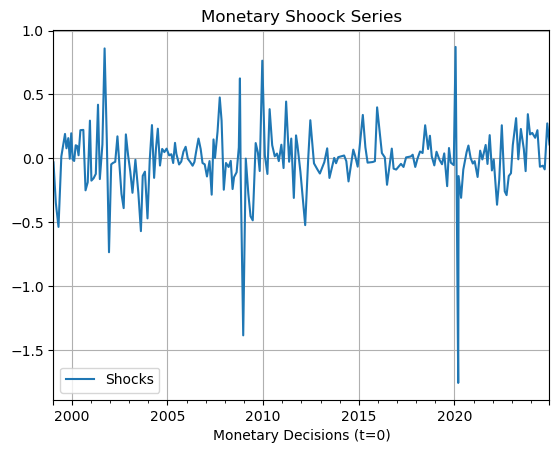

In [64]:
plt.figure()
BRW_series.plot()

plt.title("Monetary Shoock Series")
plt.grid()
plt.show()

### 2.4.2) FF4 Series

In [65]:
ff4_series = pd.DataFrame( index = daily_dates_t)
ff4_series["1Y"] =(swr_tpluss1 - swr_tmin1).astype(float)

In [66]:
swr_tpluss1

,1Y
Monetary Decisions (t=0),
1999-01-17,NaN
1999-03-03,NaN
1999-04-23,NaN
1999-06-16,6.045
1999-08-25,6.135
...,...
2024-06-20,4.844
2024-08-15,4.5776
2024-09-19,4.4624


<Axes: xlabel='Monetary Decisions (t=0)'>

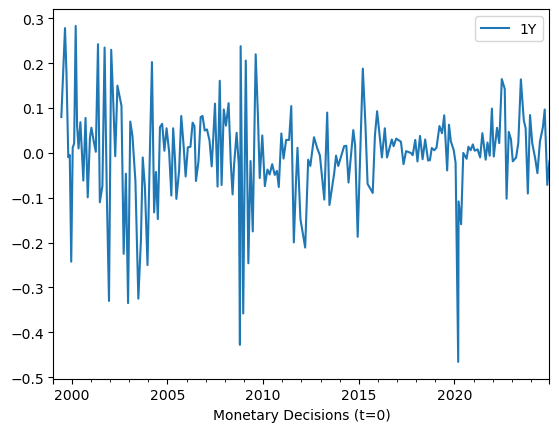

In [67]:
ff4_series.plot()

# Chapter 3) Creating Panel Dataframe

## 3.0) Definitions

#### Hypothesis 1,7,8 and 9 = H1 Frame
#### Hypothesis 2 = H2 Frame
#### Hypothesis 3 = H3 Frame
#### Hypothesis 4 = H4 Frame
#### Hypothesis 5 = H5 Frame
#### Hypothesis 6 = H6 Frame

## 3.1) H1 Frame

### 3.1.1) Firm Characteristics

#### Firm Excess Returns

In [68]:
H1_df = pd.DataFrame(columns = ["Firm Name"])
def H1(frame,shock,returns):
   
    for i in range(len(shock)):
        
        
        date_d = shock.index[i]
       
        
        
        sample = returns.loc[returns.index >= date_d ].head(8).iloc[1:,:]
       
       
        cleaned_sample = sample.dropna(axis=1, how='any')
        
    
        names = cleaned_sample.columns

    

        df_new = pd.DataFrame({"Firm Name": names}, index=np.repeat(date_d, len(names)))

    
        frame = pd.concat([frame, df_new], axis=0)
       

    return frame

    
    

In [69]:
H1_df = H1(H1_df,BRW_series,firm_excess_returns)

In [70]:
H1_df["K1"] = None
H1_df["K2"] = None
H1_df["K3"] = None
H1_df["K4"] = None
H1_df["K5"] = None
H1_df["K6"] = None
H1_df["K7"] = None
dates = H1_df.index.unique()

In [71]:
for i in range(len(dates)):
    date = dates[i]
    names = H1_df.loc[H1_df.index == date, "Firm Name"].values

   
    
    H1_df.loc[H1_df.index == date, "K1"] = pd.DataFrame(excess_lagged_1.loc[excess_lagged_1.index >= date,names]).iloc[0,:].values
    H1_df.loc[H1_df.index == date, "K2"] = pd.DataFrame(excess_lagged_2.loc[excess_lagged_2.index >= date,names]).iloc[0,:].values
    H1_df.loc[H1_df.index == date, "K3"] = pd.DataFrame(excess_lagged_3.loc[excess_lagged_3.index >= date,names]).iloc[0,:].values
    H1_df.loc[H1_df.index == date, "K4"] = pd.DataFrame(excess_lagged_4.loc[excess_lagged_4.index >= date,names]).iloc[0,:].values
    H1_df.loc[H1_df.index == date, "K5"] = pd.DataFrame(excess_lagged_5.loc[excess_lagged_5.index >= date,names]).iloc[0,:].values
    H1_df.loc[H1_df.index == date, "K6"] = pd.DataFrame(excess_lagged_6.loc[excess_lagged_6.index >= date,names]).iloc[0,:].values
    H1_df.loc[H1_df.index == date, "K7"] = pd.DataFrame(excess_lagged_7.loc[excess_lagged_7.index >= date,names]).iloc[0,:].values
    

In [72]:
H1_df

,Firm Name,K1,K2,K3,K4,K5,K6,K7
1999-01-17,SUBSEA 7,-0.023385,0.476413,0.127935,-0.079295,-0.011455,0.094693,-0.039546
1999-01-17,ABG SUNDAL COLLIER HOLDING,0.179898,0.035387,-0.038539,0.377324,-0.127532,-0.112254,0.03602
1999-01-17,NRC GROUP,-0.096201,0.053714,-0.141423,-0.108202,0.183174,-0.028921,0.025414
1999-01-17,BONHEUR,-0.012576,0.015656,0.270924,-0.062893,-0.009561,0.003943,0.043595
1999-01-17,DNB BANK,-0.088661,-0.063315,-0.085367,-0.026055,-0.051373,0.009556,0.13454
...,...,...,...,...,...,...,...,...
2024-12-19,HAUGESUND SPAREBANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-19,BRUTON,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-19,ONCOINVENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-19,TRONDELAG SPAREBANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Industry Classifications

In [73]:
H1_df["Industry"] = None

In [74]:
for i in range(len(Stock_info)):
    name = Stock_info['Company Name'][i]
    industry = Stock_info['GICS Industry Group Name'][i]
 
    H1_df.loc[H1_df["Firm Name"] == name, "Industry"] = industry 
    





In [75]:
H1_df

,Firm Name,K1,K2,K3,K4,K5,K6,K7,Industry
1999-01-17,SUBSEA 7,-0.023385,0.476413,0.127935,-0.079295,-0.011455,0.094693,-0.039546,Energy
1999-01-17,ABG SUNDAL COLLIER HOLDING,0.179898,0.035387,-0.038539,0.377324,-0.127532,-0.112254,0.03602,Financial Services
1999-01-17,NRC GROUP,-0.096201,0.053714,-0.141423,-0.108202,0.183174,-0.028921,0.025414,Capital Goods
1999-01-17,BONHEUR,-0.012576,0.015656,0.270924,-0.062893,-0.009561,0.003943,0.043595,Capital Goods
1999-01-17,DNB BANK,-0.088661,-0.063315,-0.085367,-0.026055,-0.051373,0.009556,0.13454,Banks
...,...,...,...,...,...,...,...,...,...
2024-12-19,HAUGESUND SPAREBANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Banks
2024-12-19,BRUTON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-19,ONCOINVENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Pharmaceuticals, Biotechnology & Life Sciences"
2024-12-19,TRONDELAG SPAREBANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Banks


#### Firm Market Cap

In [76]:
H1_df["Market Cap"] = None

In [77]:
for i in range(len(dates)):
    date = dates[i]
    names = H1_df.loc[H1_df.index == date, "Firm Name"].values
    
    H1_df.loc[H1_df.index == date, "Market Cap"] = lagged_filtered_MC.loc[date,names].values

In [78]:
H1_df

,Firm Name,K1,K2,K3,K4,K5,K6,K7,Industry,Market Cap
1999-01-17,SUBSEA 7,-0.023385,0.476413,0.127935,-0.079295,-0.011455,0.094693,-0.039546,Energy,NaN
1999-01-17,ABG SUNDAL COLLIER HOLDING,0.179898,0.035387,-0.038539,0.377324,-0.127532,-0.112254,0.03602,Financial Services,NaN
1999-01-17,NRC GROUP,-0.096201,0.053714,-0.141423,-0.108202,0.183174,-0.028921,0.025414,Capital Goods,NaN
1999-01-17,BONHEUR,-0.012576,0.015656,0.270924,-0.062893,-0.009561,0.003943,0.043595,Capital Goods,NaN
1999-01-17,DNB BANK,-0.088661,-0.063315,-0.085367,-0.026055,-0.051373,0.009556,0.13454,Banks,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-12-19,HAUGESUND SPAREBANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Banks,333.67
2024-12-19,BRUTON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-19,ONCOINVENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Pharmaceuticals, Biotechnology & Life Sciences",NaN
2024-12-19,TRONDELAG SPAREBANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Banks,NaN


#### Firm P/B

In [79]:
H1_df["P/B"] = None

In [80]:
for i in range(len(dates)):
    date = dates[i]
    names = H1_df.loc[H1_df.index == date, "Firm Name"].values
    
    H1_df.loc[H1_df.index == date, "P/B"] = lagged_filtered_PB.loc[date,names].values


#### Firm Margin

In [81]:
H1_df["Margin"] = None

In [82]:

for i in range(len(dates)):
    date = dates[i]
    names = H1_df.loc[H1_df.index == date, "Firm Name"].values
    
    H1_df.loc[H1_df.index == date, "Margin"] = filtered_alligned_margin.loc[date,names].values

#### Firm Debt %

In [83]:
H1_df["Debt"] = None

In [84]:

for i in range(len(dates)):
    date = dates[i]
    names = H1_df.loc[H1_df.index == date, "Firm Name"].values
    
    H1_df.loc[H1_df.index == date, "Debt"] = filtered_alligned_debt.loc[date,names].values

#### Firm Divident Yield

In [85]:
H1_df["DivYield"] = None

In [86]:
for i in range(len(dates)):
    date = dates[i]
    names = H1_df.loc[H1_df.index == date, "Firm Name"].values
    
    H1_df.loc[H1_df.index == date, "DivYield"] = filtered_alligned_dividend.loc[date,names].values

In [87]:
H1_df

,Firm Name,K1,K2,K3,K4,K5,K6,K7,Industry,Market Cap,P/B,Margin,Debt,DivYield
1999-01-17,SUBSEA 7,-0.023385,0.476413,0.127935,-0.079295,-0.011455,0.094693,-0.039546,Energy,NaN,NaN,NaN,NaN,0.0
1999-01-17,ABG SUNDAL COLLIER HOLDING,0.179898,0.035387,-0.038539,0.377324,-0.127532,-0.112254,0.03602,Financial Services,NaN,NaN,NaN,NaN,0.0
1999-01-17,NRC GROUP,-0.096201,0.053714,-0.141423,-0.108202,0.183174,-0.028921,0.025414,Capital Goods,NaN,NaN,NaN,NaN,3.14
1999-01-17,BONHEUR,-0.012576,0.015656,0.270924,-0.062893,-0.009561,0.003943,0.043595,Capital Goods,NaN,NaN,NaN,NaN,0.0
1999-01-17,DNB BANK,-0.088661,-0.063315,-0.085367,-0.026055,-0.051373,0.009556,0.13454,Banks,NaN,NaN,NaN,NaN,6.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,HAUGESUND SPAREBANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Banks,333.67,NaN,17.03,NaN,NaN
2024-12-19,BRUTON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-19,ONCOINVENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Pharmaceuticals, Biotechnology & Life Sciences",NaN,NaN,-2480.5,12.33,NaN
2024-12-19,TRONDELAG SPAREBANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Banks,NaN,NaN,4.53,NaN,NaN


### 3.1.2) Shock Variables

In [88]:
H1_df["BRW"] = None
H1_df["FF4"] = None

In [89]:

for i in range(len(BRW_series)):
    
    date = BRW_series.index[i]
    
    shock_brw = BRW_series.iloc[i,0]
    H1_df.loc[H1_df.index == date, "BRW"] = shock_brw

for i in range(len(ff4_series)):
    
    date = ff4_series.index[i]
    
    shock_ff4 = ff4_series.iloc[i,0]
    H1_df.loc[H1_df.index == date, "FF4"] = shock_ff4



### 3.1.3) Control Variables

In [90]:
H1_df["CPI"] = None
H1_df["EPU"] = None
H1_df["PMI"] = None
H1_df["EUVOL"] = None
H1_df["USD/NOK"] = None
H1_df["Unemployment"] = None
H1_df["Brent"] = None


In [91]:
for i in range(len(dates)):
    date = dates[i]
    H1_df.loc[H1_df.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H1_df.loc[H1_df.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H1_df.loc[H1_df.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H1_df.loc[H1_df.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H1_df.loc[H1_df.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H1_df.loc[H1_df.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H1_df.loc[H1_df.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    

In [92]:
H1_df

,Firm Name,K1,K2,K3,K4,K5,K6,K7,Industry,Market Cap,...,DivYield,BRW,FF4,CPI,EPU,PMI,EUVOL,USD/NOK,Unemployment,Brent
1999-01-17,SUBSEA 7,-0.023385,0.476413,0.127935,-0.079295,-0.011455,0.094693,-0.039546,Energy,NaN,...,0.0,-0.031771,NaN,2.4,90.907527,None,NaN,7.5887,3.2,10.54
1999-01-17,ABG SUNDAL COLLIER HOLDING,0.179898,0.035387,-0.038539,0.377324,-0.127532,-0.112254,0.03602,Financial Services,NaN,...,0.0,-0.031771,NaN,2.4,90.907527,None,NaN,7.5887,3.2,10.54
1999-01-17,NRC GROUP,-0.096201,0.053714,-0.141423,-0.108202,0.183174,-0.028921,0.025414,Capital Goods,NaN,...,3.14,-0.031771,NaN,2.4,90.907527,None,NaN,7.5887,3.2,10.54
1999-01-17,BONHEUR,-0.012576,0.015656,0.270924,-0.062893,-0.009561,0.003943,0.043595,Capital Goods,NaN,...,0.0,-0.031771,NaN,2.4,90.907527,None,NaN,7.5887,3.2,10.54
1999-01-17,DNB BANK,-0.088661,-0.063315,-0.085367,-0.026055,-0.051373,0.009556,0.13454,Banks,NaN,...,6.46,-0.031771,NaN,2.4,90.907527,None,NaN,7.5887,3.2,10.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,HAUGESUND SPAREBANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Banks,333.67,...,NaN,0.108766,-0.0177,2.4,365.603386,124.9,16.9607,11.0454,4.3,75.46
2024-12-19,BRUTON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.108766,-0.0177,2.4,365.603386,124.9,16.9607,11.0454,4.3,75.46
2024-12-19,ONCOINVENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Pharmaceuticals, Biotechnology & Life Sciences",NaN,...,NaN,0.108766,-0.0177,2.4,365.603386,124.9,16.9607,11.0454,4.3,75.46
2024-12-19,TRONDELAG SPAREBANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Banks,NaN,...,NaN,0.108766,-0.0177,2.4,365.603386,124.9,16.9607,11.0454,4.3,75.46


## 3.2) H2 Frame

### 3.2.1) Sorting Stocks after median value

In [93]:
Stock_info

,Identifier,Company Name,Country of Exchange,Exchange Name,GICS Industry Group Name,NAICS Industry Group Name
0,AWDR.OL,AWILCO DRILLING,Norway,MERKUR MARKET,Energy,Support Activities for Mining
1,PENR.OL,PANORO ENERGY,Norway,OSLO BORS ASA,Energy,Oil and Gas Extraction
2,SAGAS.OL,SAGA PURE,Norway,OSLO BORS ASA,Financial Services,Other Financial Investment Activities
3,WAWI.OL,WALLENIUS WILHELMSEN,Norway,OSLO BORS ASA,Transportation,"Deep Sea, Coastal, and Great Lakes Water Trans..."
4,KMCP.OL,KMC PROPERTIES,Norway,OSLO BORS ASA,Real Estate Management & Development,Lessors of Real Estate
...,...,...,...,...,...,...
297,BRUT.OL,BRUTON,Norway,MERKUR MARKET,NaN,Other Financial Investment Activities
298,ONCIN.OL,ONCOINVENT,Norway,MERKUR MARKET,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceutical and Medicine Manufacturing
299,TRSB.OL,TRONDELAG SPAREBANK,Norway,OSLO BORS ASA,Banks,Depository Credit Intermediation
300,MORLD.OL,MORELD,Norway,MERKUR MARKET,Capital Goods,"Architectural, Engineering, and Related Services"


In [94]:



def median_sorter(frame,returns, dates,info):
    result_low = pd.DataFrame(columns = ["Firm Name"])
    result_high = pd.DataFrame(columns = ["Firm Name"])

    for i in range(len(frame)): 
        dt = frame.iloc[i, :].dropna()
        names = dt.index
    
        date_d = dates[i]
        bank_names = info[info["Company Name"].isin(names)]
        drops = bank_names[bank_names["GICS Industry Group Name"].isin(["Banks", "Insurance", "Financial Services"])]["Company Name"].values

        names_list = list(names)

        # Remove the items in `drops` from the list
        for drop in drops:
            if drop in names_list:
                names_list.remove(drop)

        # Convert the list back to an Index (if needed)
        names = pd.Index(names_list)
       
     
        date = dt.name

        
        
        x = returns.loc[returns.index >= date_d, names].head(8).iloc[1:,:].dropna(axis=1, how='any').columns

        dt_new = dt[x]
        
        median = dt_new.median()

        
       

        low = dt_new[dt_new < median].index  # Firms below median
        high = dt_new[dt_new >= median].index  # Firms above median
    

        df_low = pd.DataFrame({"Firm Name": low}, index=np.repeat(date, len(low)))
        df_high = pd.DataFrame({"Firm Name": high}, index=np.repeat(date, len(high)))

        result_low = pd.concat([result_low, df_low], axis=0)  # Update 'result' instead of creating a new variable
        result_high = pd.concat([result_high, df_high], axis=0) 
        

    return result_low,result_high

    
    

In [95]:
H2_low_debt,H2_high_debt = median_sorter(filtered_alligned_debt,firm_excess_returns, daily_dates_t,Stock_info)

In [96]:
H2_low_debt

,Firm Name
2000-01-19,ELKEM
2000-01-19,ARRIBATEC GROUP
2000-01-19,NRC GROUP
2000-01-19,BONHEUR
2000-01-19,DNO
...,...
2024-12-19,SCHIBSTED A
2024-12-19,TGS
2024-12-19,NEKKAR
2024-12-19,VEIDEKKE


### 3.2.2 Excess Returns

In [97]:
H2_low_debt["K1"] = None
H2_low_debt["K2"] = None
H2_low_debt["K3"] = None
H2_low_debt["K4"] = None
H2_low_debt["K5"] = None
H2_low_debt["K6"] = None
H2_low_debt["K7"] = None

H2_high_debt["K1"] = None
H2_high_debt["K2"] = None
H2_high_debt["K3"] = None
H2_high_debt["K4"] = None
H2_high_debt["K5"] = None
H2_high_debt["K6"] = None
H2_high_debt["K7"] = None

dates = H2_low_debt.index.unique()


for i in range(len(dates )):
    date_1 = dates[i]
    names_1 = H2_low_debt.loc[date_1,"Firm Name"].values
    
    
    returns1 = excess_lagged_1.loc[excess_lagged_1.index >= date_1,names_1].iloc[0,:]
    returns2 = excess_lagged_2.loc[excess_lagged_2.index >= date_1,names_1].iloc[0,:]
    returns3 = excess_lagged_3.loc[excess_lagged_3.index >= date_1,names_1].iloc[0,:]
    returns4 = excess_lagged_4.loc[excess_lagged_4.index >= date_1,names_1].iloc[0,:]
    returns5 = excess_lagged_5.loc[excess_lagged_5.index >= date_1,names_1].iloc[0,:]
    returns6 = excess_lagged_6.loc[excess_lagged_6.index >= date_1,names_1].iloc[0,:]
    returns7 = excess_lagged_7.loc[excess_lagged_7.index >= date_1,names_1].iloc[0,:]
   

    H2_low_debt.loc[date_1,"K1"] = returns1.values
    H2_low_debt.loc[date_1,"K2"] = returns2.values
    H2_low_debt.loc[date_1,"K3"] = returns3.values
    H2_low_debt.loc[date_1,"K4"] = returns4.values
    H2_low_debt.loc[date_1,"K5"] = returns5.values
    H2_low_debt.loc[date_1,"K6"] = returns6.values
    H2_low_debt.loc[date_1,"K7"] = returns7.values


for i in range(len(dates )):
    date_2 = dates[i]
    names_2 = H2_high_debt.loc[date_2,"Firm Name"].values
    
    returns1 = excess_lagged_1.loc[excess_lagged_1.index >= date_2,names_2].iloc[0,:]
    returns2 = excess_lagged_2.loc[excess_lagged_2.index >= date_2,names_2].iloc[0,:]
    returns3 = excess_lagged_3.loc[excess_lagged_3.index >= date_2,names_2].iloc[0,:]
    returns4 = excess_lagged_4.loc[excess_lagged_4.index >= date_2,names_2].iloc[0,:]
    returns5 = excess_lagged_5.loc[excess_lagged_5.index >= date_2,names_2].iloc[0,:]
    returns6 = excess_lagged_6.loc[excess_lagged_6.index >= date_2,names_2].iloc[0,:]
    returns7 = excess_lagged_7.loc[excess_lagged_7.index >= date_2,names_2].iloc[0,:]
   

    H2_high_debt.loc[date_2,"K1"] = returns1.values
    H2_high_debt.loc[date_2,"K2"] = returns2.values
    H2_high_debt.loc[date_2,"K3"] = returns3.values
    H2_high_debt.loc[date_2,"K4"] = returns4.values
    H2_high_debt.loc[date_2,"K5"] = returns5.values
    H2_high_debt.loc[date_2,"K6"] = returns6.values
    H2_high_debt.loc[date_2,"K7"] = returns7.values
   

    

### 3.2.3) Control Vairables

In [98]:
H2_high_debt["CPI"] = None
H2_high_debt["EPU"] = None
H2_high_debt["PMI"] = None
H2_high_debt["EUVOL"] = None
H2_high_debt["USD/NOK"] = None
H2_high_debt["Unemployment"] = None
H2_high_debt["Brent"] = None

H2_low_debt["CPI"] = None
H2_low_debt["EPU"] = None
H2_low_debt["PMI"] = None
H2_low_debt["EUVOL"] = None
H2_low_debt["USD/NOK"] = None
H2_low_debt["Unemployment"] = None
H2_low_debt["Brent"] = None


dates_debt = H2_low_debt.index.unique()

In [99]:
for i in range(len(dates)):
    date = dates_debt[i]
    H2_high_debt.loc[H2_high_debt.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H2_high_debt.loc[H2_high_debt.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H2_high_debt.loc[H2_high_debt.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H2_high_debt.loc[H2_high_debt.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H2_high_debt.loc[H2_high_debt.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H2_high_debt.loc[H2_high_debt.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H2_high_debt.loc[H2_high_debt.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    
    H2_low_debt.loc[H2_low_debt.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H2_low_debt.loc[H2_low_debt.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H2_low_debt.loc[H2_low_debt.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H2_low_debt.loc[H2_low_debt.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H2_low_debt.loc[H2_low_debt.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H2_low_debt.loc[H2_low_debt.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H2_low_debt.loc[H2_low_debt.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    

### 3.2.4) Shock Variables

In [100]:
H2_high_debt["BRW"] = None
H2_high_debt["FF4"] = None

H2_low_debt["BRW"] = None
H2_low_debt["FF4"] = None

In [101]:
for i in range(len(BRW_series)):
    
    date = BRW_series.index[i]
    
    shock_brw = BRW_series.iloc[i,0]
    H2_high_debt.loc[H2_high_debt.index == date, "BRW"] = shock_brw
    H2_low_debt.loc[H2_low_debt.index == date, "BRW"] = shock_brw

for i in range(len(ff4_series)):
    
    date = ff4_series.index[i]
    
    shock_ff4 = ff4_series.iloc[i,0]
    H2_high_debt.loc[H2_high_debt.index == date, "FF4"] = shock_ff4
    H2_low_debt.loc[H2_low_debt.index == date, "FF4"] = shock_ff4



In [102]:
H2_high_debt

,Firm Name,K1,K2,K3,K4,K5,K6,K7,CPI,EPU,PMI,EUVOL,USD/NOK,Unemployment,Brent,BRW,FF4
2000-01-19,SUBSEA 7,0.002067,0.159153,-0.111884,0.179252,-0.121935,0.031315,-0.077215,2.8,60.273905,NaN,31.1,8.011,3.3,24.93,-0.009492,0.0115
2000-01-19,HEXAGON COMPOSITES,-0.136731,0.18655,0.009101,-0.080188,-0.080921,-0.03703,-0.002262,2.8,60.273905,NaN,31.1,8.011,3.3,24.93,-0.009492,0.0115
2000-01-19,KITRON,0.120869,-0.092053,0.039804,-0.157882,0.019452,-0.23686,-0.047169,2.8,60.273905,NaN,31.1,8.011,3.3,24.93,-0.009492,0.0115
2000-01-19,MOWI,0.466397,0.033898,0.152561,0.010248,0.1254,0.730368,-0.146606,2.8,60.273905,NaN,31.1,8.011,3.3,24.93,-0.009492,0.0115
2000-01-19,NORSK HYDRO,-0.073726,0.02799,0.058078,-0.001011,0.021437,-0.07508,0.043705,2.8,60.273905,NaN,31.1,8.011,3.3,24.93,-0.009492,0.0115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,PROSAFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,365.603386,124.9,16.9607,11.0454,4.3,75.46,0.108766,-0.0177
2024-12-19,SCANA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,365.603386,124.9,16.9607,11.0454,4.3,75.46,0.108766,-0.0177
2024-12-19,STOLT-NIELSEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,365.603386,124.9,16.9607,11.0454,4.3,75.46,0.108766,-0.0177
2024-12-19,SOLSTAD OFFSHORE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,365.603386,124.9,16.9607,11.0454,4.3,75.46,0.108766,-0.0177


## 3.3) H3 Frame

### 3.3.1) Sorting Stocks after median value

In [103]:
H3_low_quality,H3_high_quality = median_sorter(filtered_alligned_margin,firm_excess_returns,daily_dates_t,Stock_info)

### 3.3.2) Excess Returns

In [104]:


H3_low_quality["K1"] = None
H3_low_quality["K2"] = None
H3_low_quality["K3"] = None
H3_low_quality["K4"] = None
H3_low_quality["K5"] = None
H3_low_quality["K6"] = None
H3_low_quality["K7"] = None

H3_high_quality["K1"] = None
H3_high_quality["K2"] = None
H3_high_quality["K3"] = None
H3_high_quality["K4"] = None
H3_high_quality["K5"] = None
H3_high_quality["K6"] = None
H3_high_quality["K7"] = None

dates = H3_high_quality.index.unique()

In [105]:
H3_high_quality

,Firm Name,K1,K2,K3,K4,K5,K6,K7
1999-03-03,ELKEM,None,None,None,None,None,None,None
1999-03-03,SUBSEA 7,None,None,None,None,None,None,None
1999-03-03,BONHEUR,None,None,None,None,None,None,None
1999-03-03,DNO,None,None,None,None,None,None,None
1999-03-03,KITRON,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...
2024-12-19,STOLT-NIELSEN,None,None,None,None,None,None,None
2024-12-19,SOLSTAD OFFSHORE,None,None,None,None,None,None,None
2024-12-19,TOMRA SYSTEMS,None,None,None,None,None,None,None
2024-12-19,NEKKAR,None,None,None,None,None,None,None


In [106]:


for i in range(1,len(dates)):
    date_1 = dates[i]
    names_1 = H3_low_quality.loc[date_1,"Firm Name"].values
    
    returns1 = excess_lagged_1.loc[excess_lagged_1.index >= date_1,names_1].iloc[0,:]
    returns2 = excess_lagged_2.loc[excess_lagged_2.index >= date_1,names_1].iloc[0,:]
    returns3 = excess_lagged_3.loc[excess_lagged_3.index >= date_1,names_1].iloc[0,:]
    returns4 = excess_lagged_4.loc[excess_lagged_4.index >= date_1,names_1].iloc[0,:]
    returns5 = excess_lagged_5.loc[excess_lagged_5.index >= date_1,names_1].iloc[0,:]
    returns6 = excess_lagged_6.loc[excess_lagged_6.index >= date_1,names_1].iloc[0,:]
    returns7 = excess_lagged_7.loc[excess_lagged_7.index >= date_1,names_1].iloc[0,:]
   

    H3_low_quality.loc[date_1,"K1"] = returns1.values
    H3_low_quality.loc[date_1,"K2"] = returns2.values
    H3_low_quality.loc[date_1,"K3"] = returns3.values
    H3_low_quality.loc[date_1,"K4"] = returns4.values
    H3_low_quality.loc[date_1,"K5"] = returns5.values
    H3_low_quality.loc[date_1,"K6"] = returns6.values
    H3_low_quality.loc[date_1,"K7"] = returns7.values


for i in range(1,len(dates)):
    date_2 = dates[i]
    names_2 = H3_high_quality.loc[date_2,"Firm Name"].values
    
    returns1 = excess_lagged_1.loc[excess_lagged_1.index >= date_2,names_2].iloc[0,:]
    returns2 = excess_lagged_2.loc[excess_lagged_2.index >= date_2,names_2].iloc[0,:]
    returns3 = excess_lagged_3.loc[excess_lagged_3.index >= date_2,names_2].iloc[0,:]
    returns4 = excess_lagged_4.loc[excess_lagged_4.index >= date_2,names_2].iloc[0,:]
    returns5 = excess_lagged_5.loc[excess_lagged_5.index >= date_2,names_2].iloc[0,:]
    returns6 = excess_lagged_6.loc[excess_lagged_6.index >= date_2,names_2].iloc[0,:]
    returns7 = excess_lagged_7.loc[excess_lagged_7.index >= date_2,names_2].iloc[0,:]
   

    H3_high_quality.loc[date_2,"K1"] = returns1.values
    H3_high_quality.loc[date_2,"K2"] = returns2.values
    H3_high_quality.loc[date_2,"K3"] = returns3.values
    H3_high_quality.loc[date_2,"K4"] = returns4.values
    H3_high_quality.loc[date_2,"K5"] = returns5.values
    H3_high_quality.loc[date_2,"K6"] = returns6.values
    H3_high_quality.loc[date_2,"K7"] = returns7.values

### 3.3.3) Control Vairables

In [107]:
H3_high_quality["CPI"] = None
H3_high_quality["EPU"] = None
H3_high_quality["PMI"] = None
H3_high_quality["EUVOL"] = None
H3_high_quality["USD/NOK"] = None
H3_high_quality["Unemployment"] = None
H3_high_quality["Brent"] = None

H3_low_quality["CPI"] = None
H3_low_quality["EPU"] = None
H3_low_quality["PMI"] = None
H3_low_quality["EUVOL"] = None
H3_low_quality["USD/NOK"] = None
H3_low_quality["Unemployment"] = None
H3_low_quality["Brent"] = None

In [108]:
for i in range(len(dates)):
    date = dates[i]
    H3_high_quality.loc[H3_high_quality.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H3_high_quality.loc[H3_high_quality.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H3_high_quality.loc[H3_high_quality.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H3_high_quality.loc[H3_high_quality.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H3_high_quality.loc[H3_high_quality.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H3_high_quality.loc[H3_high_quality.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H3_high_quality.loc[H3_high_quality.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    
    H3_low_quality.loc[H3_low_quality.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H3_low_quality.loc[H3_low_quality.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H3_low_quality.loc[H3_low_quality.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H3_low_quality.loc[H3_low_quality.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H3_low_quality.loc[H3_low_quality.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H3_low_quality.loc[H3_low_quality.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H3_low_quality.loc[H3_low_quality.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    

### 3.3.4) Shock Variables

In [109]:
H3_high_quality["BRW"] = None
H3_high_quality["FF4"] = None

H3_low_quality["BRW"] = None
H3_low_quality["FF4"] = None


In [110]:
for i in range(len(BRW_series)):
    
    date = BRW_series.index[i]
    
    shock_brw = BRW_series.iloc[i,0]
    H3_high_quality.loc[H3_high_quality.index == date, "BRW"] = shock_brw
    H3_low_quality.loc[H3_low_quality.index == date, "BRW"] = shock_brw

for i in range(len(ff4_series)):
    
    date = ff4_series.index[i]
    
    shock_ff4 = ff4_series.iloc[i,0]
    H3_high_quality.loc[H3_high_quality.index == date, "FF4"] = shock_ff4
    H3_low_quality.loc[H3_low_quality.index == date, "FF4"] = shock_ff4



## 3.4) H4 Frame

### 3.4.1) Sorting Stocks after median value

In [111]:
H4_low_PB,H4_high_PB = median_sorter(lagged_filtered_PB,firm_excess_returns, daily_dates_t,Stock_info)

### 3.4.2) Excess Returns

In [112]:
dates = H4_low_PB.index.unique()

H4_low_PB["K1"] = None
H4_low_PB["K2"] = None
H4_low_PB["K3"] = None
H4_low_PB["K4"] = None
H4_low_PB["K5"] = None
H4_low_PB["K6"] = None
H4_low_PB["K7"] = None

H4_high_PB["K1"] = None
H4_high_PB["K2"] = None
H4_high_PB["K3"] = None
H4_high_PB["K4"] = None
H4_high_PB["K5"] = None
H4_high_PB["K6"] = None
H4_high_PB["K7"] = None

In [113]:


for i in range(len(dates)):
    date_1 = dates[i]
    names_1 = H4_low_PB.loc[date_1,"Firm Name"].values
    
    returns1 = excess_lagged_1.loc[excess_lagged_1.index >= date_1,names_1].iloc[0,:]
    returns2 = excess_lagged_2.loc[excess_lagged_2.index >= date_1,names_1].iloc[0,:]
    returns3 = excess_lagged_3.loc[excess_lagged_3.index >= date_1,names_1].iloc[0,:]
    returns4 = excess_lagged_4.loc[excess_lagged_4.index >= date_1,names_1].iloc[0,:]
    returns5 = excess_lagged_5.loc[excess_lagged_5.index >= date_1,names_1].iloc[0,:]
    returns6 = excess_lagged_6.loc[excess_lagged_6.index >= date_1,names_1].iloc[0,:]
    returns7 = excess_lagged_7.loc[excess_lagged_7.index >= date_1,names_1].iloc[0,:]
   

    H4_low_PB.loc[date_1,"K1"] = returns1.values
    H4_low_PB.loc[date_1,"K2"] = returns2.values
    H4_low_PB.loc[date_1,"K3"] = returns3.values
    H4_low_PB.loc[date_1,"K4"] = returns4.values
    H4_low_PB.loc[date_1,"K5"] = returns5.values
    H4_low_PB.loc[date_1,"K6"] = returns6.values
    H4_low_PB.loc[date_1,"K7"] = returns7.values


for i in range(len(dates)):
    date_2 = dates[i]
    names_2 = H4_high_PB.loc[date_2,"Firm Name"].values
    
    returns1 = excess_lagged_1.loc[excess_lagged_1.index >= date_2,names_2].iloc[0,:]
    returns2 = excess_lagged_2.loc[excess_lagged_2.index >= date_2,names_2].iloc[0,:]
    returns3 = excess_lagged_3.loc[excess_lagged_3.index >= date_2,names_2].iloc[0,:]
    returns4 = excess_lagged_4.loc[excess_lagged_4.index >= date_2,names_2].iloc[0,:]
    returns5 = excess_lagged_5.loc[excess_lagged_5.index >= date_2,names_2].iloc[0,:]
    returns6 = excess_lagged_6.loc[excess_lagged_6.index >= date_2,names_2].iloc[0,:]
    returns7 = excess_lagged_7.loc[excess_lagged_7.index >= date_2,names_2].iloc[0,:]
   

    H4_high_PB.loc[date_2,"K1"] = returns1.values
    H4_high_PB.loc[date_2,"K2"] = returns2.values
    H4_high_PB.loc[date_2,"K3"] = returns3.values
    H4_high_PB.loc[date_2,"K4"] = returns4.values
    H4_high_PB.loc[date_2,"K5"] = returns5.values
    H4_high_PB.loc[date_2,"K6"] = returns6.values
    H4_high_PB.loc[date_2,"K7"] = returns7.values

### 3.4.3) Control Vairables

In [114]:
H4_high_PB["CPI"] = None
H4_high_PB["EPU"] = None
H4_high_PB["PMI"] = None
H4_high_PB["EUVOL"] = None
H4_high_PB["USD/NOK"] = None
H4_high_PB["Unemployment"] = None
H4_high_PB["Brent"] = None

H4_low_PB["CPI"] = None
H4_low_PB["EPU"] = None
H4_low_PB["PMI"] = None
H4_low_PB["EUVOL"] = None
H4_low_PB["USD/NOK"] = None
H4_low_PB["Unemployment"] = None
H4_low_PB["Brent"] = None

In [115]:
for i in range(len(dates)):
    date = dates[i]
    H4_high_PB.loc[H4_high_PB.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H4_high_PB.loc[H4_high_PB.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H4_high_PB.loc[H4_high_PB.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H4_high_PB.loc[H4_high_PB.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H4_high_PB.loc[H4_high_PB.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H4_high_PB.loc[H4_high_PB.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H4_high_PB.loc[H4_high_PB.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    
    H4_low_PB.loc[H4_low_PB.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H4_low_PB.loc[H4_low_PB.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H4_low_PB.loc[H4_low_PB.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H4_low_PB.loc[H4_low_PB.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H4_low_PB.loc[H4_low_PB.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H4_low_PB.loc[H4_low_PB.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H4_low_PB.loc[H4_low_PB.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    

### 3.4.4) Shock Variables

In [116]:
H4_high_PB["BRW"] = None
H4_high_PB["FF4"] = None

H4_low_PB["BRW"] = None
H4_low_PB["FF4"] = None

In [117]:
for i in range(len(BRW_series)):
    
    date = BRW_series.index[i]
    
    shock_brw = BRW_series.iloc[i,0]
    H4_high_PB.loc[H4_high_PB.index == date, "BRW"] = shock_brw
    H4_low_PB.loc[H4_low_PB.index == date, "BRW"] = shock_brw

for i in range(len(ff4_series)):
    
    date = ff4_series.index[i]
    
    shock_ff4 = ff4_series.iloc[i,0]
    H4_high_PB.loc[H4_high_PB.index == date, "FF4"] = shock_ff4
    H4_low_PB.loc[H4_low_PB.index == date, "FF4"] = shock_ff4



## 3.5) H5 Frame

### 3.5.1) Sorting Stocks after median value

In [118]:
H5_low_MC,H5_high_MC = median_sorter(lagged_filtered_MC,firm_excess_returns, daily_dates_t,Stock_info)

### 3.5.2) Excess Returns

In [119]:
dates = H5_low_MC.index.unique()

H5_low_MC["K1"] = None
H5_low_MC["K2"] = None
H5_low_MC["K3"] = None
H5_low_MC["K4"] = None
H5_low_MC["K5"] = None
H5_low_MC["K6"] = None
H5_low_MC["K7"] = None

H5_high_MC["K1"] = None
H5_high_MC["K2"] = None
H5_high_MC["K3"] = None
H5_high_MC["K4"] = None
H5_high_MC["K5"] = None
H5_high_MC["K6"] = None
H5_high_MC["K7"] = None

In [120]:


for i in range(len(dates)):
    date_1 = dates[i]
    names_1 = H5_low_MC.loc[date_1,"Firm Name"].values
    
    returns1 = excess_lagged_1.loc[excess_lagged_1.index >= date_1,names_1].iloc[0,:]
    returns2 = excess_lagged_2.loc[excess_lagged_2.index >= date_1,names_1].iloc[0,:]
    returns3 = excess_lagged_3.loc[excess_lagged_3.index >= date_1,names_1].iloc[0,:]
    returns4 = excess_lagged_4.loc[excess_lagged_4.index >= date_1,names_1].iloc[0,:]
    returns5 = excess_lagged_5.loc[excess_lagged_5.index >= date_1,names_1].iloc[0,:]
    returns6 = excess_lagged_6.loc[excess_lagged_6.index >= date_1,names_1].iloc[0,:]
    returns7 = excess_lagged_7.loc[excess_lagged_7.index >= date_1,names_1].iloc[0,:]
   

    H5_low_MC.loc[date_1,"K1"] = returns1.values
    H5_low_MC.loc[date_1,"K2"] = returns2.values
    H5_low_MC.loc[date_1,"K3"] = returns3.values
    H5_low_MC.loc[date_1,"K4"] = returns4.values
    H5_low_MC.loc[date_1,"K5"] = returns5.values
    H5_low_MC.loc[date_1,"K6"] = returns6.values
    H5_low_MC.loc[date_1,"K7"] = returns7.values


for i in range(len(dates)):
    date_2 = dates[i]
    names_2 = H5_high_MC.loc[date_2,"Firm Name"].values
    
    returns1 = excess_lagged_1.loc[excess_lagged_1.index >= date_2,names_2].iloc[0,:]
    returns2 = excess_lagged_2.loc[excess_lagged_2.index >= date_2,names_2].iloc[0,:]
    returns3 = excess_lagged_3.loc[excess_lagged_3.index >= date_2,names_2].iloc[0,:]
    returns4 = excess_lagged_4.loc[excess_lagged_4.index >= date_2,names_2].iloc[0,:]
    returns5 = excess_lagged_5.loc[excess_lagged_5.index >= date_2,names_2].iloc[0,:]
    returns6 = excess_lagged_6.loc[excess_lagged_6.index >= date_2,names_2].iloc[0,:]
    returns7 = excess_lagged_7.loc[excess_lagged_7.index >= date_2,names_2].iloc[0,:]
   

    H5_high_MC.loc[date_2,"K1"] = returns1.values
    H5_high_MC.loc[date_2,"K2"] = returns2.values
    H5_high_MC.loc[date_2,"K3"] = returns3.values
    H5_high_MC.loc[date_2,"K4"] = returns4.values
    H5_high_MC.loc[date_2,"K5"] = returns5.values
    H5_high_MC.loc[date_2,"K6"] = returns6.values
    H5_high_MC.loc[date_2,"K7"] = returns7.values

### 3.5.3) Control Vairables

In [121]:
H5_high_MC["CPI"] = None
H5_high_MC["EPU"] = None
H5_high_MC["PMI"] = None
H5_high_MC["EUVOL"] = None
H5_high_MC["USD/NOK"] = None
H5_high_MC["Unemployment"] = None
H5_high_MC["Brent"] = None

H5_low_MC["CPI"] = None
H5_low_MC["EPU"] = None
H5_low_MC["PMI"] = None
H5_low_MC["EUVOL"] = None
H5_low_MC["USD/NOK"] = None
H5_low_MC["Unemployment"] = None
H5_low_MC["Brent"] = None

In [122]:
for i in range(len(dates)):
    date = dates[i]
    H5_high_MC.loc[H5_high_MC.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H5_high_MC.loc[H5_high_MC.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H5_high_MC.loc[H5_high_MC.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H5_high_MC.loc[H5_high_MC.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H5_high_MC.loc[H5_high_MC.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H5_high_MC.loc[H5_high_MC.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H5_high_MC.loc[H5_high_MC.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    
    H5_low_MC.loc[H5_low_MC.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H5_low_MC.loc[H5_low_MC.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H5_low_MC.loc[H5_low_MC.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H5_low_MC.loc[H5_low_MC.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H5_low_MC.loc[H5_low_MC.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H5_low_MC.loc[H5_low_MC.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H5_low_MC.loc[H5_low_MC.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    

### 3.5.4) Shock Variables

In [123]:
H5_high_MC["BRW"] = None
H5_high_MC["FF4"] = None

H5_low_MC["BRW"] = None
H5_low_MC["FF4"] = None

In [124]:
for i in range(len(BRW_series)):
    
    date = BRW_series.index[i]
    
    shock_brw = BRW_series.iloc[i,0]
    H5_high_MC.loc[H5_high_MC.index == date, "BRW"] = shock_brw
    H5_low_MC.loc[H5_low_MC.index == date, "BRW"] = shock_brw

for i in range(len(ff4_series)):
    
    date = ff4_series.index[i]
    
    shock_ff4 = ff4_series.iloc[i,0]
    H5_high_MC.loc[H5_high_MC.index == date, "FF4"] = shock_ff4
    H5_low_MC.loc[H5_low_MC.index == date, "FF4"] = shock_ff4



## 3.6) H6 Frame

### 3.6.1) Sorting Stocks after median value

In [125]:

def div_sorter(frame,returns, dates,info):
    result_low = pd.DataFrame(columns = ["Firm Name"])
    result_high = pd.DataFrame(columns = ["Firm Name"])

    for i in range(len(frame)): 
        dt = frame.iloc[i, :].dropna()
        names = dt.index
    
        date_d = dates[i]
       
     
        date = dt.name
        bank_names = info[info["Company Name"].isin(names)]
        drops = bank_names[bank_names["GICS Industry Group Name"] == "Banks"]["Company Name"].values
        names_list = list(names)

        # Remove the items in `drops` from the list
        for drop in drops:
            if drop in names_list:
                names_list.remove(drop)

        # Convert the list back to an Index (if needed)
        names = pd.Index(names_list)
        
        x = returns.loc[returns.index >= date_d, names].head(8).iloc[1:,:].dropna(axis=1, how='any').columns

        dt_new = dt[x]
        
        

        
       

        low = dt_new[dt_new <= 0].index  # Firms below median
        high = dt_new[dt_new > 0].index  # Firms above median

        df_low = pd.DataFrame({"Firm Name": low}, index=np.repeat(date, len(low)))
        df_high = pd.DataFrame({"Firm Name": high}, index=np.repeat(date, len(high)))

        result_low = pd.concat([result_low, df_low], axis=0)  # Update 'result' instead of creating a new variable
        result_high = pd.concat([result_high, df_high], axis=0) 
        

    return result_low,result_high

    
    

In [126]:
H6_low_DIV,H6_high_DIV = div_sorter(filtered_alligned_dividend,firm_excess_returns, daily_dates_t,Stock_info)

### 3.6.2) Excess Returns

In [127]:
dates = H6_low_DIV.index.unique()

H6_low_DIV["K1"] = None
H6_low_DIV["K2"] = None
H6_low_DIV["K3"] = None
H6_low_DIV["K4"] = None
H6_low_DIV["K5"] = None
H6_low_DIV["K6"] = None
H6_low_DIV["K7"] = None

H6_high_DIV["K1"] = None
H6_high_DIV["K2"] = None
H6_high_DIV["K3"] = None
H6_high_DIV["K4"] = None
H6_high_DIV["K5"] = None
H6_high_DIV["K6"] = None
H6_high_DIV["K7"] = None

In [128]:


for i in range(len(dates)):
    date_1 = dates[i]
    names_1 = H6_low_DIV.loc[date_1,"Firm Name"].values
    
    returns1 = excess_lagged_1.loc[excess_lagged_1.index >= date_1,names_1].iloc[0,:]
    returns2 = excess_lagged_2.loc[excess_lagged_2.index >= date_1,names_1].iloc[0,:]
    returns3 = excess_lagged_3.loc[excess_lagged_3.index >= date_1,names_1].iloc[0,:]
    returns4 = excess_lagged_4.loc[excess_lagged_4.index >= date_1,names_1].iloc[0,:]
    returns5 = excess_lagged_5.loc[excess_lagged_5.index >= date_1,names_1].iloc[0,:]
    returns6 = excess_lagged_6.loc[excess_lagged_6.index >= date_1,names_1].iloc[0,:]
    returns7 = excess_lagged_7.loc[excess_lagged_7.index >= date_1,names_1].iloc[0,:]
   

    H6_low_DIV.loc[date_1,"K1"] = returns1.values
    H6_low_DIV.loc[date_1,"K2"] = returns2.values
    H6_low_DIV.loc[date_1,"K3"] = returns3.values
    H6_low_DIV.loc[date_1,"K4"] = returns4.values
    H6_low_DIV.loc[date_1,"K5"] = returns5.values
    H6_low_DIV.loc[date_1,"K6"] = returns6.values
    H6_low_DIV.loc[date_1,"K7"] = returns7.values


for i in range(len(dates)):
    date_2 = dates[i]
    names_2 = H6_high_DIV.loc[date_2,"Firm Name"].values
    
    returns1 = excess_lagged_1.loc[excess_lagged_1.index >= date_2,names_2].iloc[0,:]
    returns2 = excess_lagged_2.loc[excess_lagged_2.index >= date_2,names_2].iloc[0,:]
    returns3 = excess_lagged_3.loc[excess_lagged_3.index >= date_2,names_2].iloc[0,:]
    returns4 = excess_lagged_4.loc[excess_lagged_4.index >= date_2,names_2].iloc[0,:]
    returns5 = excess_lagged_5.loc[excess_lagged_5.index >= date_2,names_2].iloc[0,:]
    returns6 = excess_lagged_6.loc[excess_lagged_6.index >= date_2,names_2].iloc[0,:]
    returns7 = excess_lagged_7.loc[excess_lagged_7.index >= date_2,names_2].iloc[0,:]
   

    H6_high_DIV.loc[date_2,"K1"] = returns1.values
    H6_high_DIV.loc[date_2,"K2"] = returns2.values
    H6_high_DIV.loc[date_2,"K3"] = returns3.values
    H6_high_DIV.loc[date_2,"K4"] = returns4.values
    H6_high_DIV.loc[date_2,"K5"] = returns5.values
    H6_high_DIV.loc[date_2,"K6"] = returns6.values
    H6_high_DIV.loc[date_2,"K7"] = returns7.values

### 3.6.3) Control Vairables

In [129]:
H6_high_DIV["CPI"] = None
H6_high_DIV["EPU"] = None
H6_high_DIV["PMI"] = None
H6_high_DIV["EUVOL"] = None
H6_high_DIV["USD/NOK"] = None
H6_high_DIV["Unemployment"] = None
H6_high_DIV["Brent"] = None

H6_low_DIV["CPI"] = None
H6_low_DIV["EPU"] = None
H6_low_DIV["PMI"] = None
H6_low_DIV["EUVOL"] = None
H6_low_DIV["USD/NOK"] = None
H6_low_DIV["Unemployment"] = None
H6_low_DIV["Brent"] = None

In [130]:
for i in range(len(dates)):
    date = dates[i]
    H6_high_DIV.loc[H6_high_DIV.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H6_high_DIV.loc[H6_high_DIV.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H6_high_DIV.loc[H6_high_DIV.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H6_high_DIV.loc[H6_high_DIV.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H6_high_DIV.loc[H6_high_DIV.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H6_high_DIV.loc[H6_high_DIV.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H6_high_DIV.loc[H6_high_DIV.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    
    H6_low_DIV.loc[H6_low_DIV.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H6_low_DIV.loc[H6_low_DIV.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H6_low_DIV.loc[H6_low_DIV.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H6_low_DIV.loc[H6_low_DIV.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H6_low_DIV.loc[H6_low_DIV.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H6_low_DIV.loc[H6_low_DIV.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H6_low_DIV.loc[H6_low_DIV.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    

### 3.6.4) Shock Variables

In [131]:
H6_high_DIV["BRW"] = None
H6_high_DIV["FF4"] = None

H6_low_DIV["BRW"] = None
H6_low_DIV["FF4"] = None

In [132]:
for i in range(len(BRW_series)):
    
    date = BRW_series.index[i]
    
    shock_brw = BRW_series.iloc[i,0]
    H6_high_DIV.loc[H6_high_DIV.index == date, "BRW"] = shock_brw
    H6_low_DIV.loc[H6_low_DIV.index == date, "BRW"] = shock_brw

for i in range(len(ff4_series)):
    
    date = ff4_series.index[i]
    
    shock_ff4 = ff4_series.iloc[i,0]
    H6_high_DIV.loc[H6_high_DIV.index == date, "FF4"] = shock_ff4
    H6_low_DIV.loc[H6_low_DIV.index == date, "FF4"] = shock_ff4



## 3.7) H7 Frame

### 3.7.1) Sorting Stocks after median value

In [133]:
H7_low_IRC,H7_high_IRC = median_sorter(filtered_alligned_IRC,firm_excess_returns, daily_dates_t,Stock_info)

In [134]:
H7_low_IRC

,Firm Name
2000-01-19,NRC GROUP
2000-01-19,DNO
2000-01-19,GOODTECH
2000-01-19,HEXAGON COMPOSITES
2000-01-19,ITERA
...,...
2024-12-19,PROSAFE
2024-12-19,SCHIBSTED A
2024-12-19,SCANA
2024-12-19,STOLT-NIELSEN


### 3.7.2 Excess Returns

In [135]:
H7_low_IRC["K1"] = None
H7_low_IRC["K2"] = None
H7_low_IRC["K3"] = None
H7_low_IRC["K4"] = None
H7_low_IRC["K5"] = None
H7_low_IRC["K6"] = None
H7_low_IRC["K7"] = None

H7_high_IRC["K1"] = None
H7_high_IRC["K2"] = None
H7_high_IRC["K3"] = None
H7_high_IRC["K4"] = None
H7_high_IRC["K5"] = None
H7_high_IRC["K6"] = None
H7_high_IRC["K7"] = None

dates = H7_high_IRC.index.unique()


for i in range(len(dates )):
    date_1 = dates[i]
    names_1 = H7_low_IRC.loc[date_1,"Firm Name"].values
    
    returns1 = excess_lagged_1.loc[excess_lagged_1.index >= date_1,names_1].iloc[0,:]
    returns2 = excess_lagged_2.loc[excess_lagged_2.index >= date_1,names_1].iloc[0,:]
    returns3 = excess_lagged_3.loc[excess_lagged_3.index >= date_1,names_1].iloc[0,:]
    returns4 = excess_lagged_4.loc[excess_lagged_4.index >= date_1,names_1].iloc[0,:]
    returns5 = excess_lagged_5.loc[excess_lagged_5.index >= date_1,names_1].iloc[0,:]
    returns6 = excess_lagged_6.loc[excess_lagged_6.index >= date_1,names_1].iloc[0,:]
    returns7 = excess_lagged_7.loc[excess_lagged_7.index >= date_1,names_1].iloc[0,:]
   

    H7_low_IRC.loc[date_1,"K1"] = returns1.values
    H7_low_IRC.loc[date_1,"K2"] = returns2.values
    H7_low_IRC.loc[date_1,"K3"] = returns3.values
    H7_low_IRC.loc[date_1,"K4"] = returns4.values
    H7_low_IRC.loc[date_1,"K5"] = returns5.values
    H7_low_IRC.loc[date_1,"K6"] = returns6.values
    H7_low_IRC.loc[date_1,"K7"] = returns7.values


for i in range(len(dates )):
    date_2 = dates[i]
    names_2 = H7_high_IRC.loc[date_2,"Firm Name"].values
    
    returns1 = excess_lagged_1.loc[excess_lagged_1.index >= date_2,names_2].iloc[0,:]
    returns2 = excess_lagged_2.loc[excess_lagged_2.index >= date_2,names_2].iloc[0,:]
    returns3 = excess_lagged_3.loc[excess_lagged_3.index >= date_2,names_2].iloc[0,:]
    returns4 = excess_lagged_4.loc[excess_lagged_4.index >= date_2,names_2].iloc[0,:]
    returns5 = excess_lagged_5.loc[excess_lagged_5.index >= date_2,names_2].iloc[0,:]
    returns6 = excess_lagged_6.loc[excess_lagged_6.index >= date_2,names_2].iloc[0,:]
    returns7 = excess_lagged_7.loc[excess_lagged_7.index >= date_2,names_2].iloc[0,:]
   

    H7_high_IRC.loc[date_2,"K1"] = returns1.values
    H7_high_IRC.loc[date_2,"K2"] = returns2.values
    H7_high_IRC.loc[date_2,"K3"] = returns3.values
    H7_high_IRC.loc[date_2,"K4"] = returns4.values
    H7_high_IRC.loc[date_2,"K5"] = returns5.values
    H7_high_IRC.loc[date_2,"K6"] = returns6.values
    H7_high_IRC.loc[date_2,"K7"] = returns7.values
   

    

### 3.7.3) Control Vairables

In [136]:
H7_high_IRC["CPI"] = None
H7_high_IRC["EPU"] = None
H7_high_IRC["PMI"] = None
H7_high_IRC["EUVOL"] = None
H7_high_IRC["USD/NOK"] = None
H7_high_IRC["Unemployment"] = None
H7_high_IRC["Brent"] = None

H7_low_IRC["CPI"] = None
H7_low_IRC["EPU"] = None
H7_low_IRC["PMI"] = None
H7_low_IRC["EUVOL"] = None
H7_low_IRC["USD/NOK"] = None
H7_low_IRC["Unemployment"] = None
H7_low_IRC["Brent"] = None



In [137]:
for i in range(len(dates)):
    date = dates[i]
    H7_high_IRC.loc[H7_high_IRC.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H7_high_IRC.loc[H7_high_IRC.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H7_high_IRC.loc[H7_high_IRC.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H7_high_IRC.loc[H7_high_IRC.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H7_high_IRC.loc[H7_high_IRC.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H7_high_IRC.loc[H7_high_IRC.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H7_high_IRC.loc[H7_high_IRC.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    
    H7_low_IRC.loc[H7_low_IRC.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H7_low_IRC.loc[H7_low_IRC.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H7_low_IRC.loc[H7_low_IRC.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H7_low_IRC.loc[H7_low_IRC.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H7_low_IRC.loc[H7_low_IRC.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H7_low_IRC.loc[H7_low_IRC.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H7_low_IRC.loc[H7_low_IRC.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    

### 3.7.4) Shock Variables

In [138]:
H7_high_IRC["BRW"] = None
H7_high_IRC["FF4"] = None

H7_low_IRC["BRW"] = None
H7_low_IRC["FF4"] = None

In [139]:
for i in range(len(BRW_series)):
    
    date = BRW_series.index[i]
    
    shock_brw = BRW_series.iloc[i,0]
    H7_high_IRC.loc[H7_high_IRC.index == date, "BRW"] = shock_brw
    H7_low_IRC.loc[H7_low_IRC.index == date, "BRW"] = shock_brw

for i in range(len(ff4_series)):
    
    date = ff4_series.index[i]
    
    shock_ff4 = ff4_series.iloc[i,0]
    H7_high_IRC.loc[H7_high_IRC.index == date, "FF4"] = shock_ff4
    H7_low_IRC.loc[H7_low_IRC.index == date, "FF4"] = shock_ff4



In [140]:
H7_high_IRC

,Firm Name,K1,K2,K3,K4,K5,K6,K7,CPI,EPU,PMI,EUVOL,USD/NOK,Unemployment,Brent,BRW,FF4
2000-01-19,ELKEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8,60.273905,NaN,31.1,8.011,3.3,24.93,-0.009492,0.0115
2000-01-19,ARRIBATEC GROUP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8,60.273905,NaN,31.1,8.011,3.3,24.93,-0.009492,0.0115
2000-01-19,SUBSEA 7,0.002067,0.159153,-0.111884,0.179252,-0.121935,0.031315,-0.077215,2.8,60.273905,NaN,31.1,8.011,3.3,24.93,-0.009492,0.0115
2000-01-19,BONHEUR,-0.075342,-0.045685,-0.064003,0.150475,-0.029639,-0.013021,0.135992,2.8,60.273905,NaN,31.1,8.011,3.3,24.93,-0.009492,0.0115
2000-01-19,ATEA,-0.005503,-0.169665,-0.197959,-0.120288,-0.255968,0.083093,0.100719,2.8,60.273905,NaN,31.1,8.011,3.3,24.93,-0.009492,0.0115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,TGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,365.603386,124.9,16.9607,11.0454,4.3,75.46,0.108766,-0.0177
2024-12-19,TOMRA SYSTEMS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,365.603386,124.9,16.9607,11.0454,4.3,75.46,0.108766,-0.0177
2024-12-19,NEKKAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,365.603386,124.9,16.9607,11.0454,4.3,75.46,0.108766,-0.0177
2024-12-19,VEIDEKKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,365.603386,124.9,16.9607,11.0454,4.3,75.46,0.108766,-0.0177


## 3.8) H8 Frame

### 3.8.1) Sorting Stocks after median value

In [141]:
H8_low_shortd,H8_high_shortd = median_sorter(filtered_alligned_Short_debt,firm_excess_returns, daily_dates_t,Stock_info)

### 3.8.2 Excess Returns

In [142]:
H8_low_shortd["K1"] = None
H8_low_shortd["K2"] = None
H8_low_shortd["K3"] = None
H8_low_shortd["K4"] = None
H8_low_shortd["K5"] = None
H8_low_shortd["K6"] = None
H8_low_shortd["K7"] = None

H8_high_shortd["K1"] = None
H8_high_shortd["K2"] = None
H8_high_shortd["K3"] = None
H8_high_shortd["K4"] = None
H8_high_shortd["K5"] = None
H8_high_shortd["K6"] = None
H8_high_shortd["K7"] = None

dates = H7_high_IRC.index.unique()


for i in range(len(dates )):
    date_1 = dates[i]
    names_1 = H8_low_shortd.loc[date_1,"Firm Name"].values
    
    returns1 = excess_lagged_1.loc[excess_lagged_1.index >= date_1,names_1].iloc[0,:]
    returns2 = excess_lagged_2.loc[excess_lagged_2.index >= date_1,names_1].iloc[0,:]
    returns3 = excess_lagged_3.loc[excess_lagged_3.index >= date_1,names_1].iloc[0,:]
    returns4 = excess_lagged_4.loc[excess_lagged_4.index >= date_1,names_1].iloc[0,:]
    returns5 = excess_lagged_5.loc[excess_lagged_5.index >= date_1,names_1].iloc[0,:]
    returns6 = excess_lagged_6.loc[excess_lagged_6.index >= date_1,names_1].iloc[0,:]
    returns7 = excess_lagged_7.loc[excess_lagged_7.index >= date_1,names_1].iloc[0,:]
   

    H8_low_shortd.loc[date_1,"K1"] = returns1.values
    H8_low_shortd.loc[date_1,"K2"] = returns2.values
    H8_low_shortd.loc[date_1,"K3"] = returns3.values
    H8_low_shortd.loc[date_1,"K4"] = returns4.values
    H8_low_shortd.loc[date_1,"K5"] = returns5.values
    H8_low_shortd.loc[date_1,"K6"] = returns6.values
    H8_low_shortd.loc[date_1,"K7"] = returns7.values


for i in range(len(dates )):
    date_2 = dates[i]
    names_2 = H8_high_shortd.loc[date_2,"Firm Name"].values
    
    returns1 = excess_lagged_1.loc[excess_lagged_1.index >= date_2,names_2].iloc[0,:]
    returns2 = excess_lagged_2.loc[excess_lagged_2.index >= date_2,names_2].iloc[0,:]
    returns3 = excess_lagged_3.loc[excess_lagged_3.index >= date_2,names_2].iloc[0,:]
    returns4 = excess_lagged_4.loc[excess_lagged_4.index >= date_2,names_2].iloc[0,:]
    returns5 = excess_lagged_5.loc[excess_lagged_5.index >= date_2,names_2].iloc[0,:]
    returns6 = excess_lagged_6.loc[excess_lagged_6.index >= date_2,names_2].iloc[0,:]
    returns7 = excess_lagged_7.loc[excess_lagged_7.index >= date_2,names_2].iloc[0,:]
   

    H8_high_shortd.loc[date_2,"K1"] = returns1.values
    H8_high_shortd.loc[date_2,"K2"] = returns2.values
    H8_high_shortd.loc[date_2,"K3"] = returns3.values
    H8_high_shortd.loc[date_2,"K4"] = returns4.values
    H8_high_shortd.loc[date_2,"K5"] = returns5.values
    H8_high_shortd.loc[date_2,"K6"] = returns6.values
    H8_high_shortd.loc[date_2,"K7"] = returns7.values
   

    

### 3.8.3) Control Vairables

In [143]:
H8_high_shortd["CPI"] = None
H8_high_shortd["EPU"] = None
H8_high_shortd["PMI"] = None
H8_high_shortd["EUVOL"] = None
H8_high_shortd["USD/NOK"] = None
H8_high_shortd["Unemployment"] = None
H8_high_shortd["Brent"] = None

H8_low_shortd["CPI"] = None
H8_low_shortd["EPU"] = None
H8_low_shortd["PMI"] = None
H8_low_shortd["EUVOL"] = None
H8_low_shortd["USD/NOK"] = None
H8_low_shortd["Unemployment"] = None
H8_low_shortd["Brent"] = None



In [144]:
for i in range(len(dates)):
    date = dates[i]
    H8_high_shortd.loc[H8_high_shortd.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H8_high_shortd.loc[H8_high_shortd.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H8_high_shortd.loc[H8_high_shortd.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H8_high_shortd.loc[H8_high_shortd.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H8_high_shortd.loc[H8_high_shortd.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H8_high_shortd.loc[H8_high_shortd.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H8_high_shortd.loc[H8_high_shortd.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    
    H8_low_shortd.loc[H8_low_shortd.index == date, "CPI"] = filtered_lagged_CPI.loc[filtered_lagged_CPI.index == date].values
    H8_low_shortd.loc[H8_low_shortd.index == date, "EPU"] = filtered_lagged_EPU.loc[filtered_lagged_EPU.index == date,"GEPU_current"]
    H8_low_shortd.loc[H8_low_shortd.index == date, "PMI"] = filtered_lagged_PPI.loc[filtered_lagged_PPI.index == date].values
    H8_low_shortd.loc[H8_low_shortd.index == date, "EUVOL"] = filtered_lagged_EU_vol.loc[filtered_lagged_EU_vol.index == date].iloc[0,0]
    H8_low_shortd.loc[H8_low_shortd.index == date, "USD/NOK"] = filtered_lagged_USD_NOK.loc[filtered_lagged_USD_NOK.index == date].values
    H8_low_shortd.loc[H8_low_shortd.index == date, "Unemployment"] = filtered_lagged_Unemployment.loc[filtered_lagged_Unemployment.index == date].values
    H8_low_shortd.loc[H8_low_shortd.index == date, "Brent"] = filtered_lagged_Brent_price.loc[filtered_lagged_Brent_price.index == date]
    

### 3.8.4) Shock Variables

In [145]:
H8_high_shortd["BRW"] = None
H8_high_shortd["FF4"] = None

H8_low_shortd["BRW"] = None
H8_low_shortd["FF4"] = None

In [146]:
for i in range(len(BRW_series)):
    
    date = BRW_series.index[i]
    
    shock_brw = BRW_series.iloc[i,0]
    H8_high_shortd.loc[H8_high_shortd.index == date, "BRW"] = shock_brw
    H8_low_shortd.loc[H8_low_shortd.index == date, "BRW"] = shock_brw

for i in range(len(ff4_series)):
    
    date = ff4_series.index[i]
    
    shock_ff4 = ff4_series.iloc[i,0]
    H8_high_shortd.loc[H8_high_shortd.index == date, "FF4"] = shock_ff4
    H8_low_shortd.loc[H8_low_shortd.index == date, "FF4"] = shock_ff4



# Chapter 4) Summary Statistics and Stationarity

## 4.1) Dependent Variable

## 4.1.1) OSEAX Returns

In [147]:
OSEAX_returns.describe()

,OSEAX
count,313.000000
mean,0.009234
std,0.055045
min,-0.252155
25%,-0.017627
50%,0.012999
75%,0.039844
max,0.158295


In [148]:
adfuller(OSEAX_returns)

(-15.494971536209517,
 2.4572232559760145e-28,
 0,
 312,
 {'1%': -3.4514843502727306,
  '5%': -2.8708485956333556,
  '10%': -2.571729625657462},
 -876.0905223203301)

## 4.1.2) Firm Returns

In [149]:
firm_stacked_returns = pd.DataFrame(firm_returns.stack(dropna=False)).reset_index()[0].dropna()

In [150]:
firm_stacked_returns.describe()

count    42303.000000
mean         0.008563
std          0.280573
min         -0.982456
25%         -0.059302
50%          0.000000
75%          0.057906
max         34.000000
Name: 0, dtype: float64

In [151]:
adfuller(firm_stacked_returns)

(-19.54066045761365,
 0.0,
 52,
 42250,
 {'1%': -3.4305047857360065,
  '5%': -2.8616084118398923,
  '10%': -2.566806413407934},
 11963.27140516047)

## 4.1.3) Excess Returns

In [152]:
H1_df[["K1","K2","K3","K4","K5","K6","K7"]].stack(dropna=True).reset_index()[0].astype(float).describe()

count    154044.000000
mean         -0.000718
std           0.212243
min          -0.998384
25%          -0.072433
50%          -0.011407
75%           0.053652
max          19.189331
Name: 0, dtype: float64

In [153]:
adfuller(H1_df[["K1","K2","K3","K4","K5","K6","K7"]].stack(dropna=True).reset_index()[0].astype(float).describe())

(-18025.186020704914,
 0.0,
 0,
 7,
 {'1%': -4.9386902332361515,
  '5%': -3.477582857142857,
  '10%': -2.8438679591836733},
 38.44067480023541)

In [154]:
firm_stacked_excess_returns = pd.DataFrame(firm_excess_returns.stack(dropna=False)).reset_index()[0].dropna()

In [155]:
firm_stacked_excess_returns.describe()

count    34869.000000
mean        -0.001398
std          0.211653
min         -0.998384
25%         -0.072808
50%         -0.011959
75%          0.052840
max         19.189331
Name: 0, dtype: float64

In [156]:
adfuller(firm_stacked_excess_returns)

(-27.789243353133156,
 0.0,
 30,
 34838,
 {'1%': -3.4305377197857405,
  '5%': -2.8616229674943154,
  '10%': -2.566814160991743},
 -9440.187261478284)

## 4.1) Independent Variable

## 4.1.1) Shock Variables

### BRW

In [157]:
BRW_series.describe()

,Shocks
count,207.000000
mean,-0.010085
std,0.263831
min,-1.757792
25%,-0.091615
50%,-0.008933
75%,0.093542
max,0.871695


In [158]:
adfuller(BRW_series)

(-14.36446898000824,
 9.724719177984893e-27,
 0,
 206,
 {'1%': -3.4624988216864776,
  '5%': -2.8756749365852587,
  '10%': -2.5743041549627677},
 42.52436678136695)

### FF4

In [159]:
ff4_series.dropna().describe()

,1Y
count,204.000000
mean,-0.002389
std,0.112307
min,-0.466000
25%,-0.043125
50%,0.006000
75%,0.055000
max,0.283250


In [160]:
adfuller(ff4_series.dropna())

(-6.429603489192453,
 1.7103863603250285e-08,
 3,
 200,
 {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225},
 -295.9206698427589)

## 4.1.2) Controll Variables

### CPI

In [161]:
filtered_lagged_CPI.describe()

,CPI
count,207.000000
mean,2.471498
std,1.453021
min,-1.800000
25%,1.500000
50%,2.200000
75%,3.150000
max,7.500000


In [162]:
adfuller(filtered_lagged_CPI)

(-3.179406331102143,
 0.02120809821278747,
 8,
 198,
 {'1%': -3.4638151713286316,
  '5%': -2.876250632135043,
  '10%': -2.574611347821651},
 377.75015446066277)

### PPI

In [163]:
filtered_lagged_PPI.astype(float).describe()

,PMI
count,197.000000
mean,67.467513
std,31.077419
min,28.300000
25%,42.700000
50%,67.400000
75%,79.600000
max,181.600000


In [164]:
adfuller(filtered_lagged_PPI.astype(float).dropna())

(-0.22221150523085353,
 0.9358217565643363,
 13,
 183,
 {'1%': -3.466598080268425,
  '5%': -2.8774669520682674,
  '10%': -2.5752604356654425},
 1108.9200918813297)

### Unemmployment

In [165]:
filtered_lagged_Unemployment.astype(float).describe()

,Unemployment
count,207.000000
mean,3.721256
std,0.674668
min,2.100000
25%,3.300000
50%,3.600000
75%,4.100000
max,5.400000


In [166]:
adfuller(filtered_lagged_Unemployment.astype(float))

(-3.0085514100764295,
 0.034103486755673575,
 0,
 206,
 {'1%': -3.4624988216864776,
  '5%': -2.8756749365852587,
  '10%': -2.5743041549627677},
 51.21356023313035)

### USD/NOK

In [167]:
filtered_lagged_USD_NOK.describe()

,USD/NOK
count,207.000000
mean,7.632673
std,1.566647
min,5.054600
25%,6.197150
50%,7.718800
75%,8.779450
max,11.045400


In [168]:
adfuller(filtered_lagged_USD_NOK)

(-0.378435435508532,
 0.9136375038225033,
 0,
 206,
 {'1%': -3.4624988216864776,
  '5%': -2.8756749365852587,
  '10%': -2.5743041549627677},
 71.78138085038876)

### EPU

In [169]:
filtered_lagged_EPU.describe()

,GEPU_current,GEPU_ppp
count,207.000000,207.000000
mean,143.321829,145.792655
std,78.756708,82.490973
min,49.228251,51.196427
25%,79.627460,79.548861
50%,118.432221,118.910383
75%,193.535452,202.172468
max,431.786135,437.168877


In [170]:
adfuller(filtered_lagged_EPU["GEPU_current"])

(-0.6614118729144418,
 0.8564932024738221,
 10,
 196,
 {'1%': -3.464161278384219,
  '5%': -2.876401960790147,
  '10%': -2.5746921001665974},
 1870.0496314583995)

### EU Vol 

In [171]:
filtered_lagged_EU_vol.describe()

,EU Volatility
count,206.000000
mean,23.557847
std,8.753865
min,12.120800
25%,17.382950
50%,21.835100
75%,27.444575
max,61.340000


In [172]:
adfuller(filtered_lagged_EU_vol.dropna())

(-3.4755900579684202,
 0.00863657471736294,
 3,
 202,
 {'1%': -3.4631437906252636,
  '5%': -2.8759570379821047,
  '10%': -2.574454682874228},
 1217.065921338839)

### Brent Price

In [173]:
filtered_lagged_Brent_price.describe()

,Brent
count,207.000000
mean,63.924783
std,30.117039
min,10.540000
25%,35.920000
50%,65.090000
75%,83.390000
max,130.230000


In [174]:
adfuller(filtered_lagged_Brent_price)

(-2.4499339780778255,
 0.12813580432667693,
 0,
 206,
 {'1%': -3.4624988216864776,
  '5%': -2.8756749365852587,
  '10%': -2.5743041549627677},
 1376.9663037870478)

# Chapter 5) Exporting DataFrames

## 5.1) H1 DataFrames 

In [175]:
H1_df.to_excel("Data/Finished Dataframes/H1_df.xlsx")

## 5.2) H2 DataFrames 

In [176]:
H2_low_debt.to_excel("Data/Finished Dataframes/H2_low_debt.xlsx")
H2_high_debt.to_excel("Data/Finished Dataframes/H2_high_debt.xlsx")

## 5.3) H3 DataFrames 

In [177]:
H3_low_quality.to_excel("Data/Finished Dataframes/H3_low_quality.xlsx")
H3_high_quality.to_excel("Data/Finished Dataframes/H3_high_quality.xlsx")

## 5.4) H4 DataFrames 

In [178]:
H4_low_PB.to_excel("Data/Finished Dataframes/H4_low_PB.xlsx")
H4_high_PB.to_excel("Data/Finished Dataframes/H4_high_PB.xlsx")

## 5.5) H5 DataFrames 

In [179]:
H5_low_MC.to_excel("Data/Finished Dataframes/H5_low_MC.xlsx")
H5_high_MC.to_excel("Data/Finished Dataframes/H5_high_MC.xlsx")

## 5.6) H6 DataFrames 

In [180]:
H6_low_DIV.to_excel("Data/Finished Dataframes/H6_low_DIV.xlsx")
H6_high_DIV.to_excel("Data/Finished Dataframes/H6_high_DIV.xlsx")

## 5.7) H7 DataFrames 

In [181]:
H7_low_IRC.to_excel("Data/Finished Dataframes/H7_low_IRC.xlsx")
H7_high_IRC.to_excel("Data/Finished Dataframes/H7_high_IRC.xlsx")

## 5.8) H8 DataFrames 

In [182]:
H8_low_shortd.to_excel("Data/Finished Dataframes/H8_low_shortd.xlsx")
H8_high_shortd.to_excel("Data/Finished Dataframes/H8_high_shortd.xlsx")